# Assignment 3

# Authors: 
- Enzo Benoit-Jeannin 
- Sasha Denouvilliez-Pech 

# Imports

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Environment Setup

In [3]:
mtn_car = gym.make('MountainCar-v0')
cart_pole = gym.make('CartPole-v1')

mtn_car.reset()
cart_pole.reset()

# Maximum number of possible iterations (default was 200)
mtn_car._max_episode_steps = 1000

# Get the action space and observation space
print(mtn_car.action_space)
print(mtn_car.observation_space)

print(cart_pole.action_space)
print(cart_pole.observation_space)

Discrete(3)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


From OpenAI Gym websites [here](https://www.gymlibrary.dev/environments/classic_control/mountain_car/) and [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), we know that for the mountain car environment, both the position of the car along the x-axis and the velocity of the car can range from $-\infty$ to $+\infty$. However we know the position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07]. We will therefore use these ranges as maximum and minimum values when defining Tiles for this environment. The episode ends after length 200 or when the car reaches the flag, which is at position greater than or equal to 0.5. Note that in this environment, the reward is -1 in case of failure during an epiosde. Since 200 steps is relatively small for our models to learn, we decide to set the maximum number of steps to 1,000 for this environment. This will allow our models to have time to learn and not get contiunous rewards of -200.

Similarly, for the cart pole environment, the position of the cart along the x-axis can range from -4.8 to 4.8 but the episode terminates if the cart leaves the (-2.4, 2.4) range. The pole angle can range from -0.418 rad to 0.418 rad , but the episode terminates if the pole angle is not in the range (-.2095,.2095). The velocity of the cart and the angular velocity of the pole can both range from $-\infty$ to $+\infty$.

In [ ]:
min_cart_velocity = np.inf
max_cart_velocity = -np.inf
min_angular_velocity = np.inf
max_angular_velocity = -np.inf

for i in tqdm(range(500000)):
    for actions in [0,1]:
        cart_pole.reset()
        while True:
            observation, reward, done, _ = cart_pole.step(actions)
            min_cart_velocity = min(min_cart_velocity, observation[1])
            max_cart_velocity = max(max_cart_velocity, observation[1])
            min_angular_velocity = min(min_angular_velocity, observation[3])
            max_angular_velocity = max(max_angular_velocity, observation[3])
            if done:
                break
print("Min cart velocity: ", min_cart_velocity)
print("Max cart velocity: ", max_cart_velocity)
print("Min angular velocity: ", min_angular_velocity)
print("Max angular velocity: ", max_angular_velocity)

100%|██████████| 500000/500000 [02:47<00:00, 2981.78it/s]

Min cart velocity:  -2.19741
Max cart velocity:  2.1973631
Min angular velocity:  -3.335971
Max angular velocity:  3.3363504


In order to get the most precise range for the cart velocity and pole angular velocity, a quick experiment is run to try to estimate a sensible range. The cart velocity is set to [-3.4, 3.4] and the pole angular velocity is set to [-2.2, 2.2]. Since, the ranges are estimates not preventing samples from going beyond those values, some adjusments will be made in the tile coding.

## Tile Coding

This Tile Coding implementation is inspired form [here](https://github.com/MeepMoop/tilecoding).

In [5]:
class TileCoder:
  def __init__(self, tiles_per_dim, limits, num_tilings, offset_function=lambda n: 2 * np.arange(n) + 1):
        """
        Initializes a Feature Mapper based on tile coding technique.

        Parameters:
        - tiles_per_dim (list): Number of tiles for each dimension/axis of the input.
        - limits (list of tuples): Limits (min, max) for each dimension/axis of the input.
        - num_tilings (int): Number of overlapping tilings to use.
        - offset_function (function): Function to calculate offsets for each tiling. Default is a linear offset.
        """

        # Adjusting tile dimensions to account for tiling overlap
        adjusted_tile_dims = np.array(np.ceil(tiles_per_dim), dtype=int) + 1

        # Computing offsets for each tiling based on the provided offset function
        self.tiling_offsets = offset_function(len(tiles_per_dim)) * \
                              np.repeat([np.arange(num_tilings)], len(tiles_per_dim), axis=0).T / float(num_tilings) % 1

        # Storing the range limits for each dimension
        self.limits = np.array(limits)

        # Normalizing dimensions to scale inputs to [0, number of tiles per axis)
        self.normalized_dimensions = np.array(tiles_per_dim) / (self.limits[:, 1] - self.limits[:, 0])

        # Calculating the base index for each tiling
        self.base_indices = np.prod(adjusted_tile_dims) * np.arange(num_tilings)

        # Generating a hashing vector for tile indexing
        self.hashing_vector = np.array([np.prod(adjusted_tile_dims[0:i]) for i in range(len(tiles_per_dim))])

        # Total number of tiles across all tilings
        self.total_tiles = num_tilings * np.prod(adjusted_tile_dims)

  def get_state_vector(self, state_vector):
      """
      Computes the active tiles for a given state vector.

      Parameters:
      - state_vector (np.array): state vector for which to compute active tiles.

      Returns:
      - A numpy array of active tile indices.
      """
      # Clamp the active tile indices to ensure they are within the valid range
      state_vector = np.clip(state_vector, self.limits[:, 0], self.limits[:, 1])
      # Calculate the offset coordinates for each tiling
      adjusted_coords = ((state_vector - self.limits[:, 0]) * self.normalized_dimensions + self.tiling_offsets).astype(int)

      # Determine the active tile indices
      active_tiles = self.base_indices + np.dot(adjusted_coords, self.hashing_vector)

      return active_tiles

  def get_one_hot_state_vector(self, state_vector):
      """
      Computes the active tiles for a given state vector returning a one hot encoded vectore
      as per the guideliens of the assignment

        Parameters:
        - state_vector (np.array): state vector for which to compute active tiles.

        Returns:
        - A numpy array of active tile indices in one hot encoded format.
      """
      state_vector = self.get_state_vector(state_vector)
      one_hot = np.zeros(self.total_tiles)
      one_hot[state_vector] = 1
      return one_hot

We now proceed to test the tilecoder by feeding it two close states and verifying the state vectors are close.

In [7]:
test_tile_coder = TileCoder(tiles_per_dim=[8,8,8,8], limits=[[-2.4, 2.4], [-3.4, 3.4], [-.2095,.2095], [-2.2, 2.2]], num_tilings=8)

# Print the active tiles for the state (-0.1, 0.03, 0.05, -1)
print("Active tiles for state s1 (-0.1, 0.03, 0.05, -1):", test_tile_coder.get_state_vector([-0.1, 0.03, 0.05, -1]))

# Print the active tiles for a close state (-0.1, 0.02, 0.06, -1.01)
print("Active tiles for a close state s2 (-0.1, 0.02, 0.06, -1.01):", test_tile_coder.get_state_vector([-0.1, 0.02, 0.06, -1.01]))

Active tiles for state s1 (-0.1, 0.03, 0.05, -1): [ 1821  9192 15025 21586 28147 34708 41269 47830]
Active tiles for a close state s2 (-0.1, 0.02, 0.06, -1.01): [ 1902  9192 15025 21667 28147 34708 41269 47830]


# 1: Value-based methods with linear function approximation

### Q-Learning with linear function

The implementation of Q-Learning with linear function approximation was inspired by the following [source](https://stats.stackexchange.com/questions/187110/how-to-fit-weights-into-q-values-with-linear-function-approximation).

In [8]:
class LinearQApproximator:
    def __init__(self, action_space_size, state_dimension):
        """
        Initializes parameters of the Q-function uniformly between -0.001, 0.001.

        Parameters:
        - action_space_size (int): number of possible actions.
        - state_dimension (int): dimension of the state vector.
        """
        # Initialize theta as a matrix of zeros with shape (numebr of actions, state vector dimension).
        self.theta = np.random.uniform(-0.001, 0.001, (action_space_size, state_dimension))

    def epsilon_greedy_policy(self, q_values, epsilon):
        """
        Selects an action using an epsilon-greedy policy.

        Parameters:
        - q_values (np.array): all Q-values for the current state.
        - epsilon (float): probability of choosing a random action.

        Returns:
        - int: The action selected.
        """
        # With probability epsilon, choose a random action.
        if np.random.rand() < epsilon:
            return np.random.randint(len(q_values))
        else:
            return np.argmax(q_values)

    def predict(self, state, action=None):
        """
        Predicts Q-values for all actions for a given state or for a specific action.

        Parameters:
        - state (np.array): 1-hot encoded state vector
        - action (int, optional): action for which to predict Q-value. If None, predict for all actions.

        Returns:
        - np.array or float: The predicted Q-values for the given state (and action).
        """
        if action is None:
            return np.dot(self.theta, state)
        else:
            return np.dot(self.theta[action], state)

    def update(self, state, action, target, learning_rate):
        """
        Updates the parameters θ for a given state-action pair based on the target Q-value.

        Parameters:
        - state (np.array): 1-hot encoded state vector
        - action (int): action a.
        - target (float): target Q-value for the state-action pair.
        - learning_rate (float): learning rate (alpha) = hyperparameter to control size of update to our parameters.
        """
        # Predict the current Q-value.
        q_value = self.predict(state, action)
        # Compute the error between the target Q-value and the predicted Q-value.
        error = target - q_value
        # Update the parameters theta for the given action based on the error.
        self.theta[action] += learning_rate * error * state

        if np.isnan(self.theta).any():
          raise ValueError("theta contains NaN")

In [6]:
def q_learning(env, linear_q_approximator, tile_coder, episodes, learning_rate, gamma, epsilon):
    """
    Implements the Q-learning algorithm using a linear function approximation.

    Parameters:
    - env: environment object.
    - linear_q_approximator (LinearQApproximator): linear Q-approximator.
    - tile_coder (TileCoder): Tile coder for discretizing the state space
    - episodes (int): number of episodes to run.
    - learning_rate (float): learning rate value for updates.
    - gamma (float): discount factor.
    - epsilon (float): The exploration rate for the epsilon-greedy policy.
    """
    rewards_per_episode = []
    test_rewards= []

    # TODO: testing: 10 episodes use epislon to 0, use argmax only
    # Log some test reward
    # Print test return Can do bar ploit for testing. Average them and make bar plot.

    for _ in range(episodes):
        initial_state = env.reset()[0]   # Reset environment to start a new episode
        state_vector = tile_coder.get_one_hot_state_vector(initial_state) # Get the active tiles for the initial state

        done = False
        total_reward = 0

        while not done:
            q_values = linear_q_approximator.predict(state_vector)  # Predict Q-values for the current state
            action = linear_q_approximator.epsilon_greedy_policy(q_values, epsilon)  # Select an action using epsilon-greedy policy

            next_state, reward, done, truncated, _ = env.step(action)  # Take the action and observe the next state and reward

            next_state_vector = tile_coder.get_one_hot_state_vector(next_state)

            next_q_values = linear_q_approximator.predict(next_state_vector)  # Predict Q-values for the next state

            if done:
                target = reward
            else:
                target = reward + gamma * np.max(next_q_values)  # Compute the target for the current state-action pair
            
            linear_q_approximator.update(state_vector, action, target, learning_rate)  # Update the parameters of the Q-function

            state_vector = next_state_vector  # Move to the next state

            total_reward += reward

            if truncated:
                break

        rewards_per_episode.append(total_reward)

    # Testing phase (greedy policy), for 10 episodes
    for _ in range(10):
        state = env.reset()[0]
        state_vector = tile_coder.get_one_hot_state_vector(state)
        done = False
        total_test_reward = 0

        while not done:
            q_values = linear_q_approximator.predict(state_vector)
            action = np.argmax(q_values)  # Greedy action selection

            next_state, reward, done, truncated, _ = env.step(action)
            state_vector = tile_coder.get_one_hot_state_vector(next_state)
            total_test_reward += reward

            if truncated:
                break

        test_rewards.append(total_test_reward)

    return rewards_per_episode, test_rewards

### Expected Sarsa with linear function

In [ ]:
def expected_sarsa(env, linear_q_approximator, tile_coder, episodes, learning_rate, gamma, epsilon):
    """
    Implements the Expected Sarsa algorithm using a linear function approximation.

    Parameters:
    - env: environment object
    - linear_q_approximator (LinearQApproximator): linear Q-approximator.
    - tile_coder (TileCoder): Tile coder for discretizing the state space
    - episodes (int): number of episodes to run.
    - learning_rate (float): learning rate value for updates.
    - gamma (float): discount factor.
    - epsilon (float): The exploration rate for the epsilon-greedy policy.
    """
    rewards_per_episode = []
    test_rewards= []

    # TODO: testing: 10 episodes use epislon to 0, use argmax only
    # Log some test reward
    # Print test return Can do bar ploit for testing. Average them and make bar plot.

    for _ in range(episodes):
        initial_state = env.reset()[0] # Reset environment to start a new episode
        state_vector = tile_coder.get_one_hot_state_vector(initial_state) # Get the active tiles for the initial state
        previous_action = None

        done = False
        total_reward = 0

        while not done:
            q_values = linear_q_approximator.predict(state_vector)  # Predict Q-values for the current state
            action = linear_q_approximator.epsilon_greedy_policy(q_values, epsilon)  # Select an action using epsilon-greedy policy

            next_state, reward, done, truncated, _ = env.step(action)  # Take the action and observe the next state and reward

            next_state_vector = tile_coder.get_one_hot_state_vector(next_state)

            next_q_values = linear_q_approximator.predict(next_state_vector)  # Predict Q-values for the next state

            if done: 
              target = reward

            else:
              policy = np.ones(env.action_space.n) * epsilon / env.action_space.n  # Epsilon-greedy policy
              policy[np.argmax(next_q_values)] += 1 - epsilon
              target = reward + gamma * np.dot(next_q_values, policy)  # Expectation over all actions

            if previous_action != None:
              linear_q_approximator.update(state_vector, previous_action, target, learning_rate)  # Update the parameters of the Q-function

            state_vector = next_state_vector
            previous_action = action

            total_reward += reward

            if truncated:
                break

        rewards_per_episode.append(total_reward)

    # Testing phase (greedy policy), for 10 episodes
    for _ in range(10):
        state = env.reset()[0]
        state_vector = tile_coder.get_one_hot_state_vector(state)
        done = False
        total_test_reward = 0

        while not done:
            q_values = linear_q_approximator.predict(state_vector)
            action = np.argmax(q_values)  # Greedy action selection

            next_state, reward, done, truncated, _ = env.step(action)
            state_vector = tile_coder.get_one_hot_state_vector(next_state)
            total_test_reward += reward

            if truncated:
                break

        test_rewards.append(total_test_reward)

    return rewards_per_episode, test_rewards

### Experiment Helper Functions

In [9]:
def save_checkpoint(results, test_results, checkpoint_path="checkpoint.npz"):
    """
    Saves the current state of the experiment to a file.
    """
    np.savez(checkpoint_path, results=results, test_results=test_results)

def load_checkpoint(checkpoint_path="checkpoint.npz"):
    """
    Loads the experiment state from a file if it exists.
    """
    if os.path.exists(checkpoint_path):
        with np.load(checkpoint_path) as data:
            return data['results'], data['test_results']
    else:
        return None, None

In [10]:
def run_q_experiment(env, episodes, trials, epsilons, learning_rates, tile_coder):
    results = np.zeros((len(epsilons), len(learning_rates), trials, episodes))
    test_results = np.zeros((len(epsilons), len(learning_rates), trials, 10))

    for epsilon_index, epsilon in enumerate(epsilons):
        for lr_index, learning_rate in enumerate(learning_rates):
            for trial in range(trials):
                # Check if this trial was already completed (results are non-zero)
                if np.any(results[epsilon_index, lr_index, trial, :]):
                    continue  # trial already been completed

                print(f" ---- Epsilon: {epsilon}, Learning Rate: {learning_rate} ----")
                # Initialize the Q-approximator with environment-specific dimensions
                approximator = LinearQApproximator(env.action_space.n, tile_coder.total_tiles)
                total_rewards, test_rewards = q_learning(env, approximator, tile_coder, episodes, learning_rate, 0.99, epsilon)
                results[epsilon_index, lr_index, trial, :] = total_rewards
                test_results[epsilon_index, lr_index, trial, :] = test_rewards
                del approximator

                # Print summary for the current trial
                avg_train_reward = np.mean(total_rewards)
                avg_test_reward = np.mean(test_rewards)
                print(f'[{epsilon}, {learning_rate}, Trial {trial+1}] Avg Train Reward: {avg_train_reward:.2f}, Avg Test Reward: {avg_test_reward:.2f}')
    return results, test_results

In [ ]:
def run_exp_sarsa_experiment(env, episodes, trials, epsilons, learning_rates, tile_coder):
    results = np.zeros((len(epsilons), len(learning_rates), trials, episodes))
    test_results = np.zeros((len(epsilons), len(learning_rates), trials, 10))

    for epsilon_index, epsilon in enumerate(epsilons):
        for lr_index, learning_rate in enumerate(learning_rates):
            for trial in range(trials):
                print(f" ---- Epsilon: {epsilon}, Learning Rate: {learning_rate} ----")
                # Initialize the Q-approximator with environment-specific dimensions
                approximator = LinearQApproximator(env.action_space.n, tile_coder.total_tiles)
                total_rewards, test_rewards = expected_sarsa(env, approximator, tile_coder, episodes, learning_rate, 0.99, epsilon)
                results[epsilon_index, lr_index, trial, :] = total_rewards
                test_results[epsilon_index, lr_index, trial, :] = test_rewards
                del approximator

                # Print summary for the current trial
                avg_train_reward = np.mean(total_rewards)
                avg_test_reward = np.mean(test_rewards)
                print(f'[{epsilon}, {learning_rate}, Trial {trial+1}] Avg Train Reward: {avg_train_reward:.2f}, Avg Test Reward: {avg_test_reward:.2f}')
    return results, test_results

In [152]:
def plot_results(results, title, epsilons, learning_rates, num_episodes):
    # Adjust for a 2x5 grid. Last subplot in the second row will be unused.
    fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Adjust figsize as needed
    fig.suptitle(title)

    plot_counter = 0  # Keep track of which subplot we're plotting in
    for epsilon_index, epsilon in enumerate(epsilons):
        for lr_index, learning_rate in enumerate(learning_rates):
            # Calculate subplot row and column
            row = plot_counter // 5
            col = plot_counter % 5

            ax = axs[row, col]
            data = results[epsilon_index, lr_index, :, :]
            means = np.mean(data, axis=0)
            lower_bound = np.quantile(data, 0.25, axis=0)
            upper_bound = np.quantile(data, 0.75, axis=0)

            ax.fill_between(np.arange(1, num_episodes + 1), lower_bound, upper_bound, alpha=0.2)
            ax.plot(np.arange(1, num_episodes + 1), means, label=f'ε={epsilon}, LR={learning_rate}')
            ax.set_title(f'ε={epsilon}, LR={learning_rate}')
            ax.set_xlabel('Episodes')
            ax.set_ylabel('Average Total Reward')
            ax.legend(loc='upper left')

            plot_counter += 1  # Move to the next subplot for the next iteration

    # Optionally, hide the last plot in the second row if it's unused
    if plot_counter < 10:
        axs[1, 4].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def plot_test_results(test_results, epsilons, learning_rates):
    # Average over test episodes for each trial
    avg_over_episodes = np.mean(test_results, axis=3)

    # Average over all trials
    final_avg_test_returns = np.mean(avg_over_episodes, axis=2)

    # Prepare data for plotting
    num_combinations = len(epsilons) * len(learning_rates)
    avg_returns_flat = final_avg_test_returns.flatten()
    labels = [f'ε={eps}, LR={lr}' for eps in epsilons for lr in learning_rates]

    # Plotting
    plt.figure(figsize=(12, 6))
    x_positions = np.arange(num_combinations)
    plt.bar(x_positions, avg_returns_flat, tick_label=labels, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel('Hyperparameter Combinations (Epsilon, Learning Rate)')
    plt.ylabel('Average Test Return')
    plt.title('Average Test Returns Across Hyperparameter Combinations')
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

### Mountain Car Experiments

#### Q-Learning

To allow for better learning, the learning rates are divided by the number of tilings as mentioned in the [textbook](http://incompleteideas.net/book/RLbook2020.pdf) p.218.

In [ ]:
# Experiment parameters
epsilons = [0.1, 0.05, 0.01]  # Exploration rates , 0.05, 0.01
num_tilings = 10
learning_rates = np.array([1/4, 1/8, 1/16]) / num_tilings  # Step sizes
num_trials = 50
num_episodes = 1000
tile_coder = TileCoder(tiles_per_dim=[8,8], limits=[[-1.2, 0.6], [-0.07, 0.07]], num_tilings=num_tilings)

QL_mtnCar_experiment_results, QL_mtnCar_experiment_test_results = run_q_experiment(mtn_car, num_episodes, num_trials, epsilons, learning_rates, tile_coder)

 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 1] Avg Train Reward: -154.70, Avg Test Reward: -103.30
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 2] Avg Train Reward: -154.66, Avg Test Reward: -127.00
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 3] Avg Train Reward: -154.12, Avg Test Reward: -119.50
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 4] Avg Train Reward: -154.32, Avg Test Reward: -104.00
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 5] Avg Train Reward: -154.06, Avg Test Reward: -103.50
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 6] Avg Train Reward: -154.02, Avg Test Reward: -130.30
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 7] Avg Train Reward: -156.14, Avg Test Reward: -113.20
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 8] Avg Train Reward: -155.81, Avg Test Reward: -99.50
 ---- Epsilon: 0.1, Learning Rate: 0.025 

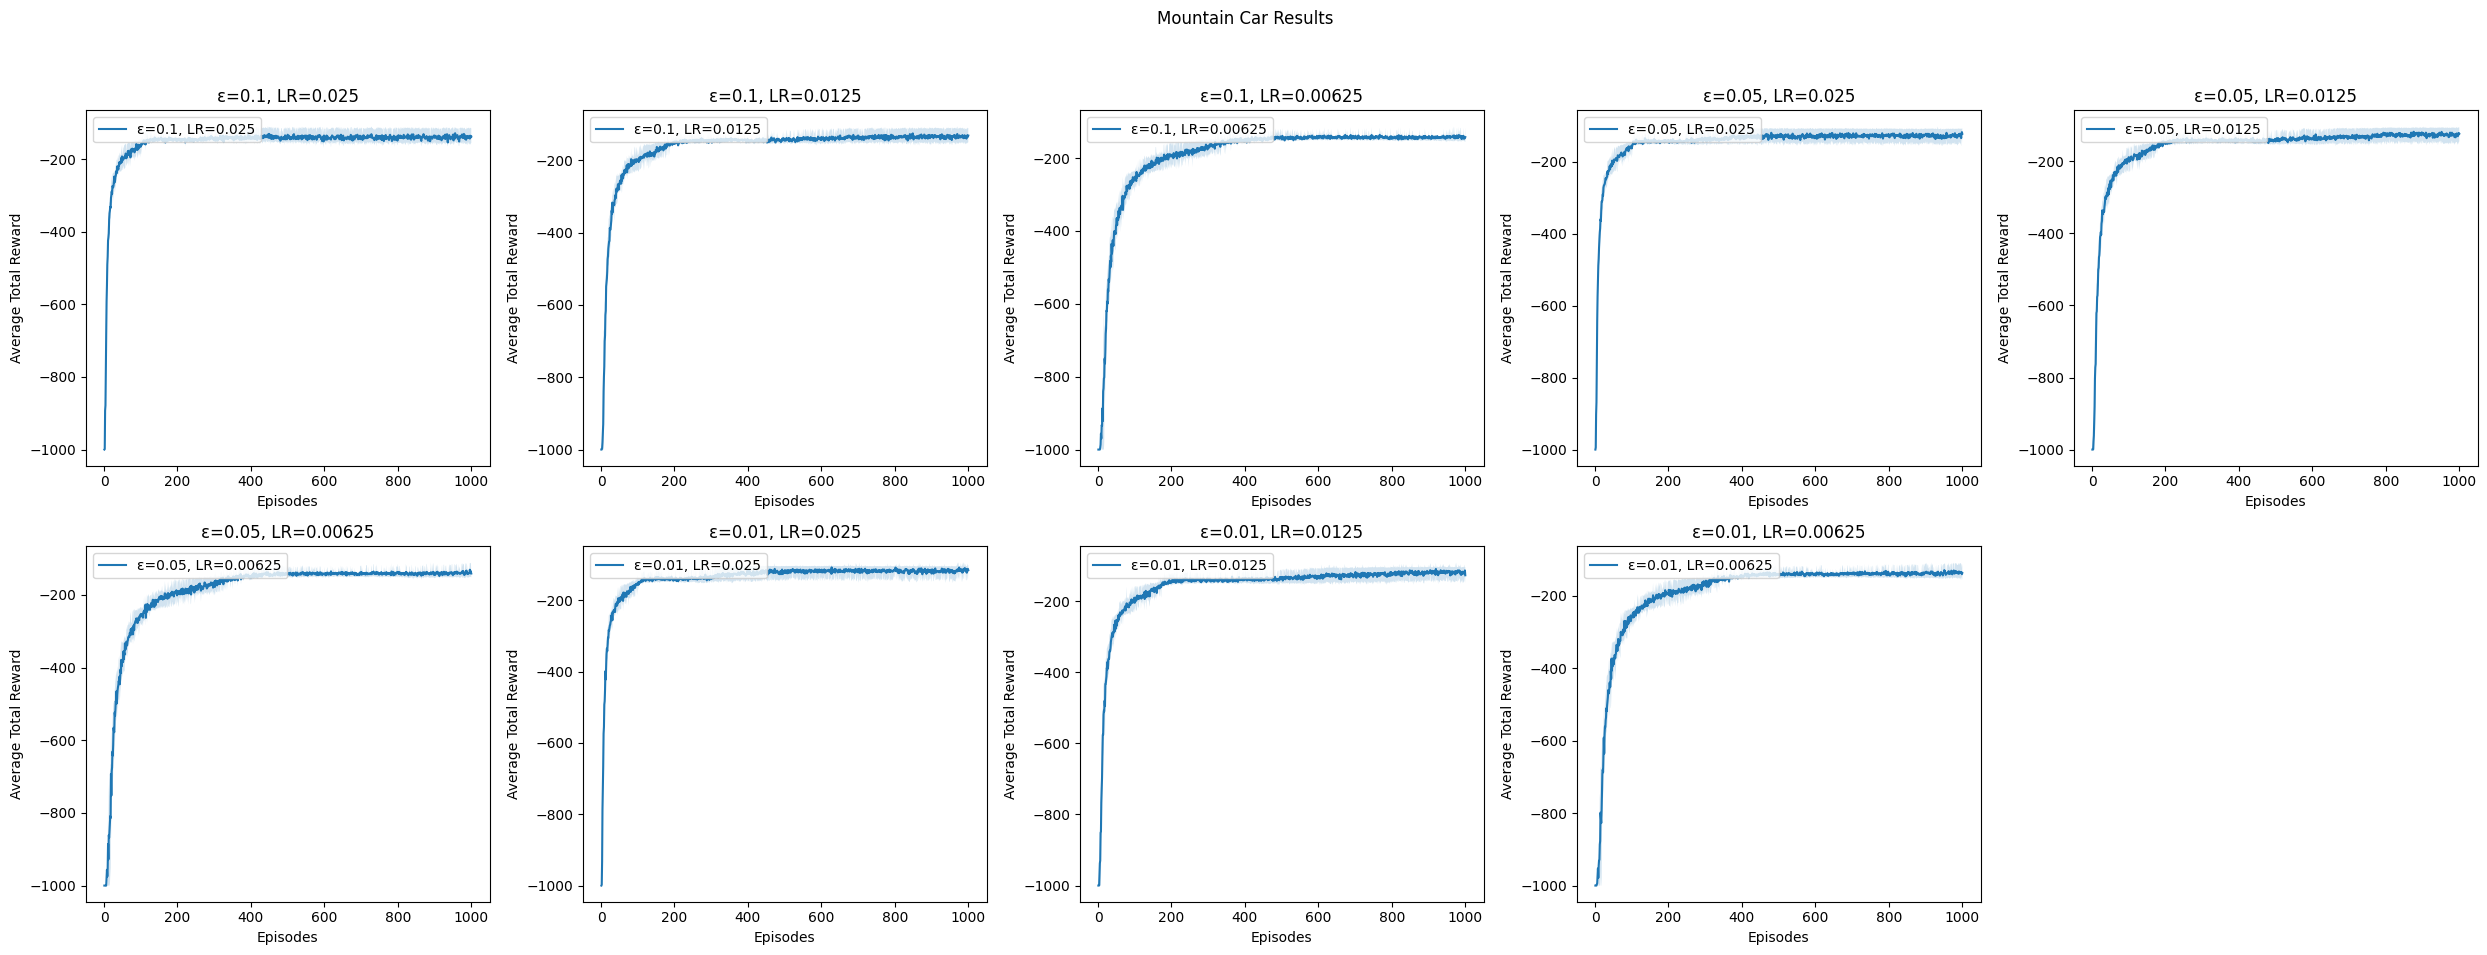

In [ ]:
plot_results(QL_mtnCar_experiment_results, 'Mountain Car Results', epsilons, learning_rates, num_episodes)

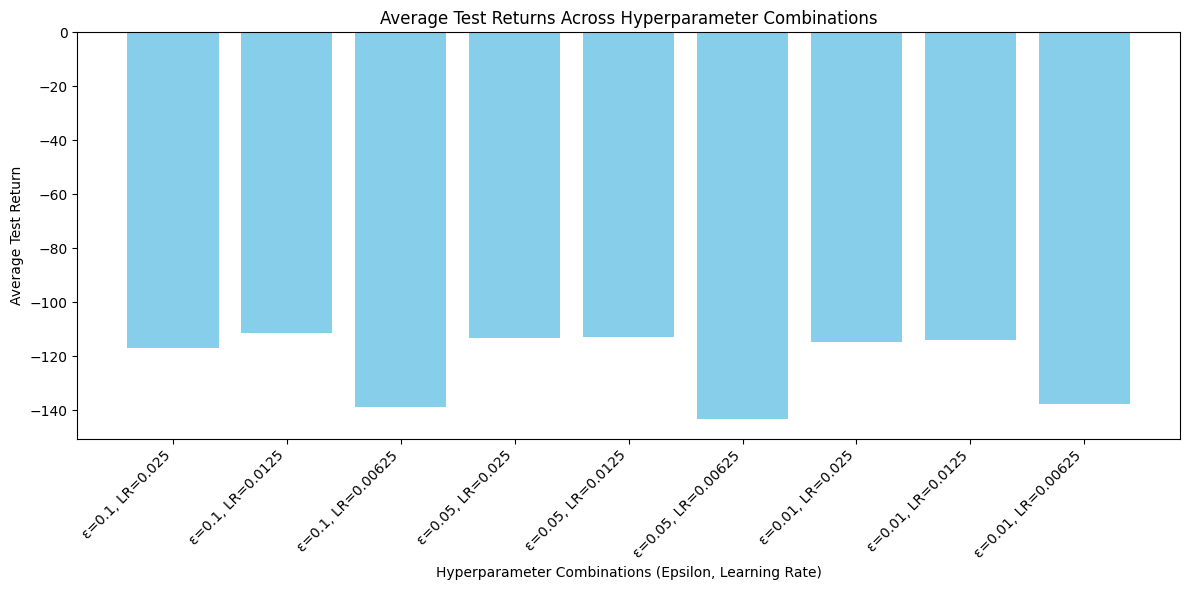

In [ ]:
plot_test_results(QL_mtnCar_experiment_test_results, epsilons, learning_rates)

The Q-Learning algorithm seems to learn fairly well on the Mountain Car environment as can be shown by the training and test results. The maximum number of steps was set to 1000 to increase the amount of training per episode. The different hyperparameter combinations perform uniformly across both training and testing. It is worth noting slightly bigger learning rates, 0.025 and 0.0125, btoh lead to better testing rewards than using a learning rate of 0.00625.

#### Expected SARSA

In [ ]:
# Experiment parameters
epsilons = [0.1, 0.05, 0.01]  # Exploration rates , 0.05, 0.01
num_tilings = 10
learning_rates = np.array([1/4, 1/8, 1/16]) / num_tilings  # Step sizes
num_trials = 50
num_episodes = 1000
tile_coder = TileCoder(tiles_per_dim=[8,8], limits=[[-1.2, 0.6], [-0.07, 0.07]], num_tilings=num_tilings)

ES_mtnCar_experiment_results, ES_mtnCar_experiment_test_results = run_exp_sarsa_experiment(mtn_car, num_episodes, num_trials, epsilons, learning_rates, tile_coder)

 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 1] Avg Train Reward: -284.75, Avg Test Reward: -149.60
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 2] Avg Train Reward: -272.06, Avg Test Reward: -132.90
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 3] Avg Train Reward: -270.66, Avg Test Reward: -167.40
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 4] Avg Train Reward: -258.33, Avg Test Reward: -146.00
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 5] Avg Train Reward: -267.11, Avg Test Reward: -395.20
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 6] Avg Train Reward: -281.64, Avg Test Reward: -143.50
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 7] Avg Train Reward: -255.15, Avg Test Reward: -126.40
 ---- Epsilon: 0.1, Learning Rate: 0.025 ----
[0.1, 0.025, Trial 8] Avg Train Reward: -269.76, Avg Test Reward: -166.80
 ---- Epsilon: 0.1, Learning Rate: 0.025

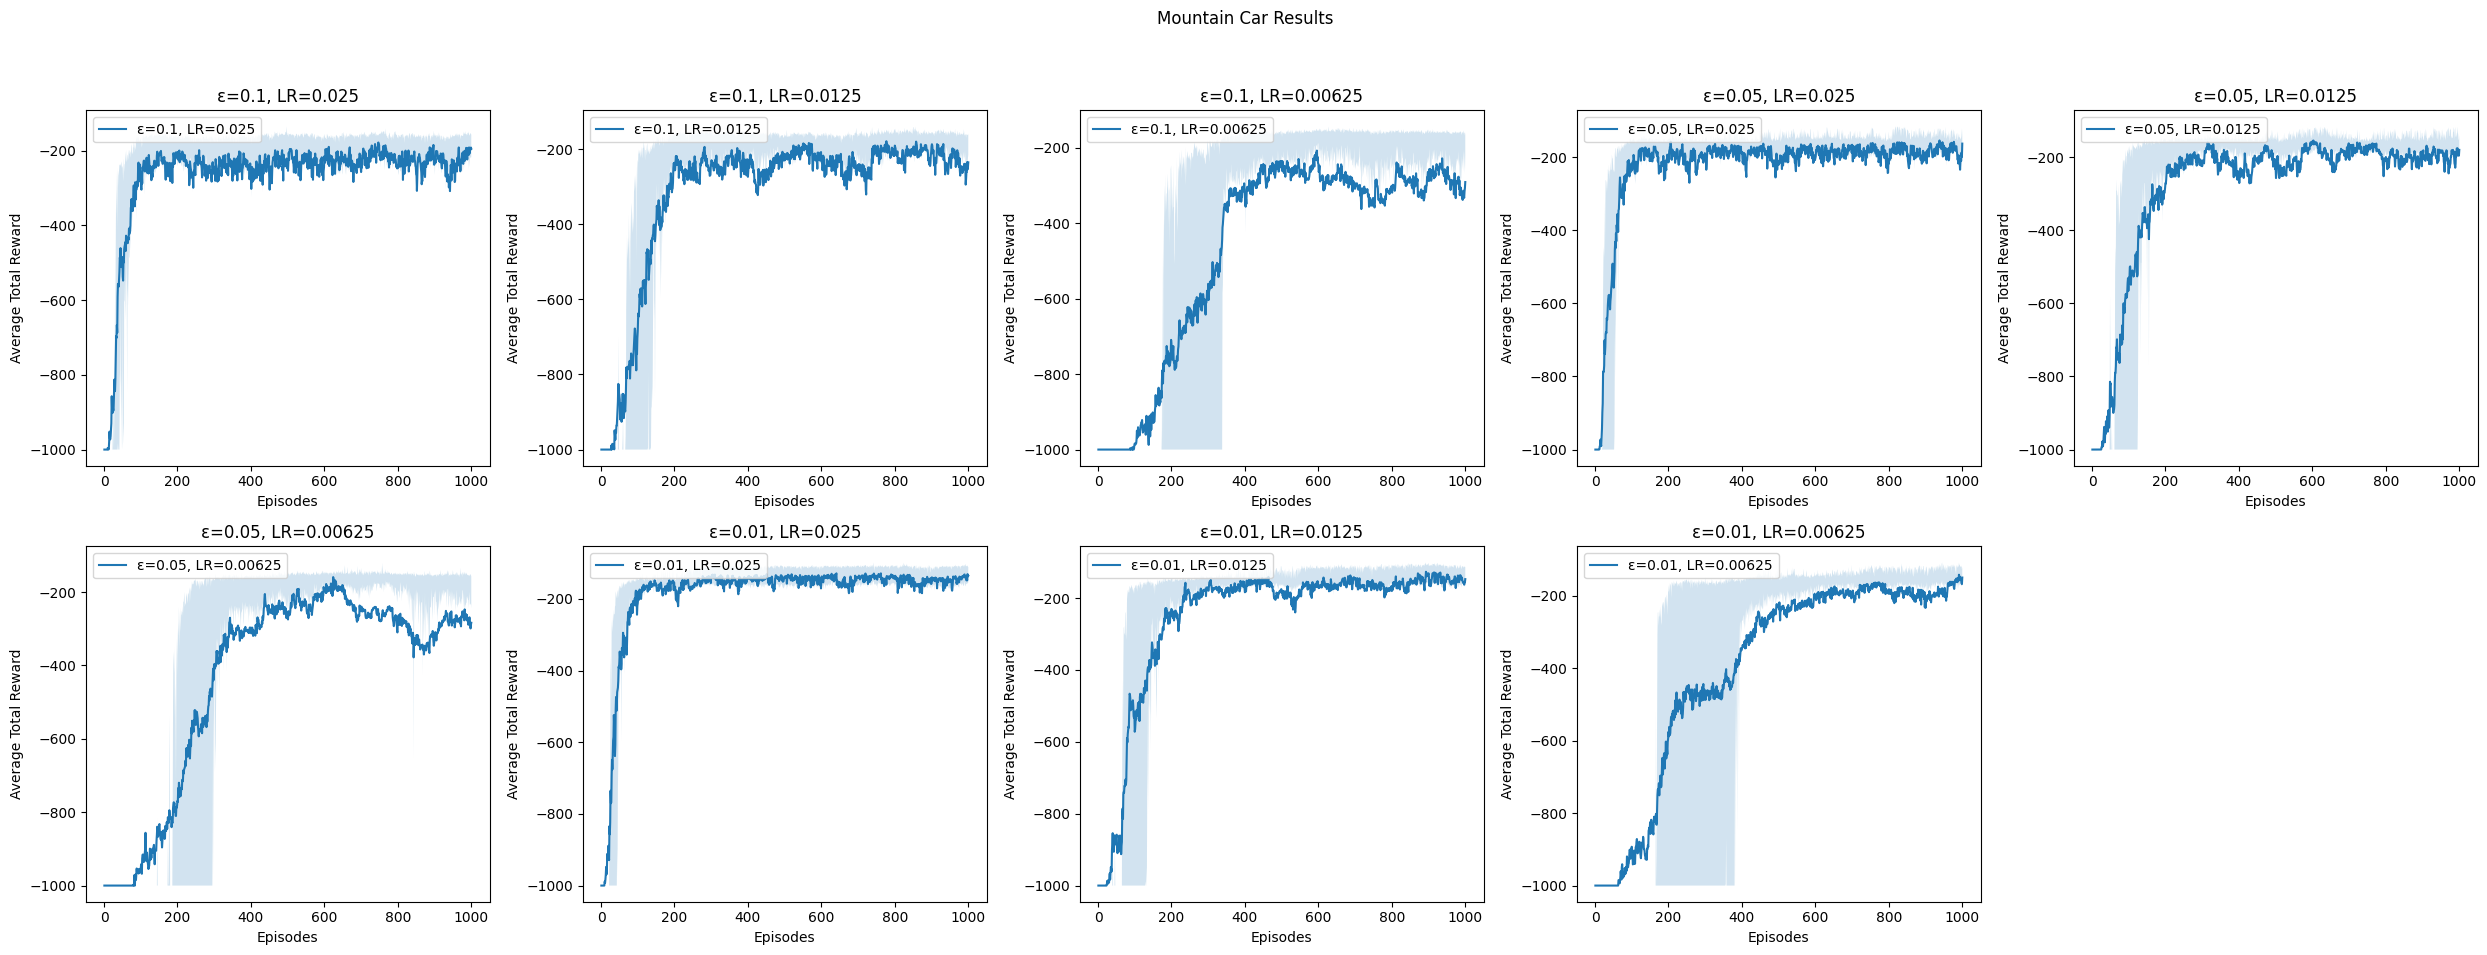

In [ ]:
plot_results(ES_mtnCar_experiment_results, 'Mountain Car Results', epsilons, learning_rates, num_episodes)

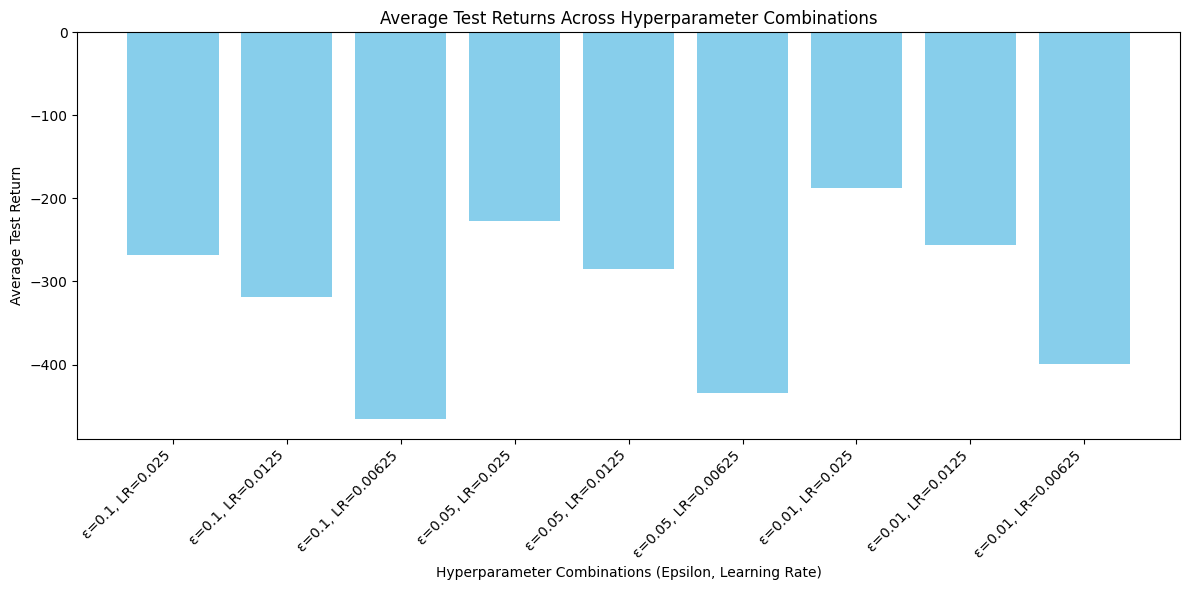

In [ ]:
plot_test_results(ES_mtnCar_experiment_results, epsilons, learning_rates)

The Expected Sarsa algorithm learns well on the mountain car environment. The training results are much more volatile than for Q-Learning and also more conservative. It is alaso worth noting that learning is not as quick and smooth as it was for Q-learning. This is highlighted by the usual "jump" we can observe on the average total training reward suddenly increasing wihtin the first 300 episodes. These jumps seem to be less consistent in terms of episode at which they occur with the 0.00625 learning rate as the interquantile range is wider indicating more variance in performance from one trial to the other. Test results are also much lower compared to Q-Learning. Interestingly, bigger learning rate and smaller $\epsilon$ perform better overall. As Q-learning tends to prioritize exploration more aggressively compared to Expected Sarsa, it could explain the difference in performance. However, Expected Sarsa seemed to not benefit from more exploration during training, i.e. higher $\epsilon$.

### Cart Pole Experiments

#### Q-Learning

As previously mentioned, the learning rate is divided by the number of tiles. Since the cart pole environment contains higher dimensions, it is more computationally heavy to keep a high number of tiles. In a effort to reduce training time while not compromising on learning, the number of tilings is set to 4.

In [ ]:
# Experiment parameters
epsilons = [0.1, 0.05, 0.01]  # Exploration rates
num_tilings = 4
learning_rates = np.array([1/4, 1/8, 1/16]) / num_tilings  # Step sizes
num_trials = 50
num_episodes = 1000
tile_coder = TileCoder(tiles_per_dim=[8,8,8,8], limits=[[-2.4, 2.4], [-3.4, 3.4], [-.2095,.2095], [-2.2, 2.2]], num_tilings=num_tilings)

QL_cartPole_experiment_results, QL_cartPole_experiment_test_results = run_q_experiment(cart_pole, num_episodes, num_trials, epsilons, learning_rates, tile_coder)

 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 1] Avg Train Reward: 332.69, Avg Test Reward: 320.60
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 2] Avg Train Reward: 133.62, Avg Test Reward: 263.00
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 3] Avg Train Reward: 287.15, Avg Test Reward: 500.00
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 4] Avg Train Reward: 258.32, Avg Test Reward: 494.30
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 5] Avg Train Reward: 170.73, Avg Test Reward: 500.00
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 6] Avg Train Reward: 227.75, Avg Test Reward: 289.10
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 7] Avg Train Reward: 280.91, Avg Test Reward: 486.90
 ---- Epsilon: 0.1, Learning Rate: 0.0625 ----
[0.1, 0.0625, Trial 8] Avg Train Reward: 347.68, Avg Test Reward: 389.60
 ---- Epsilon: 0.1, Learning Rate: 0.062

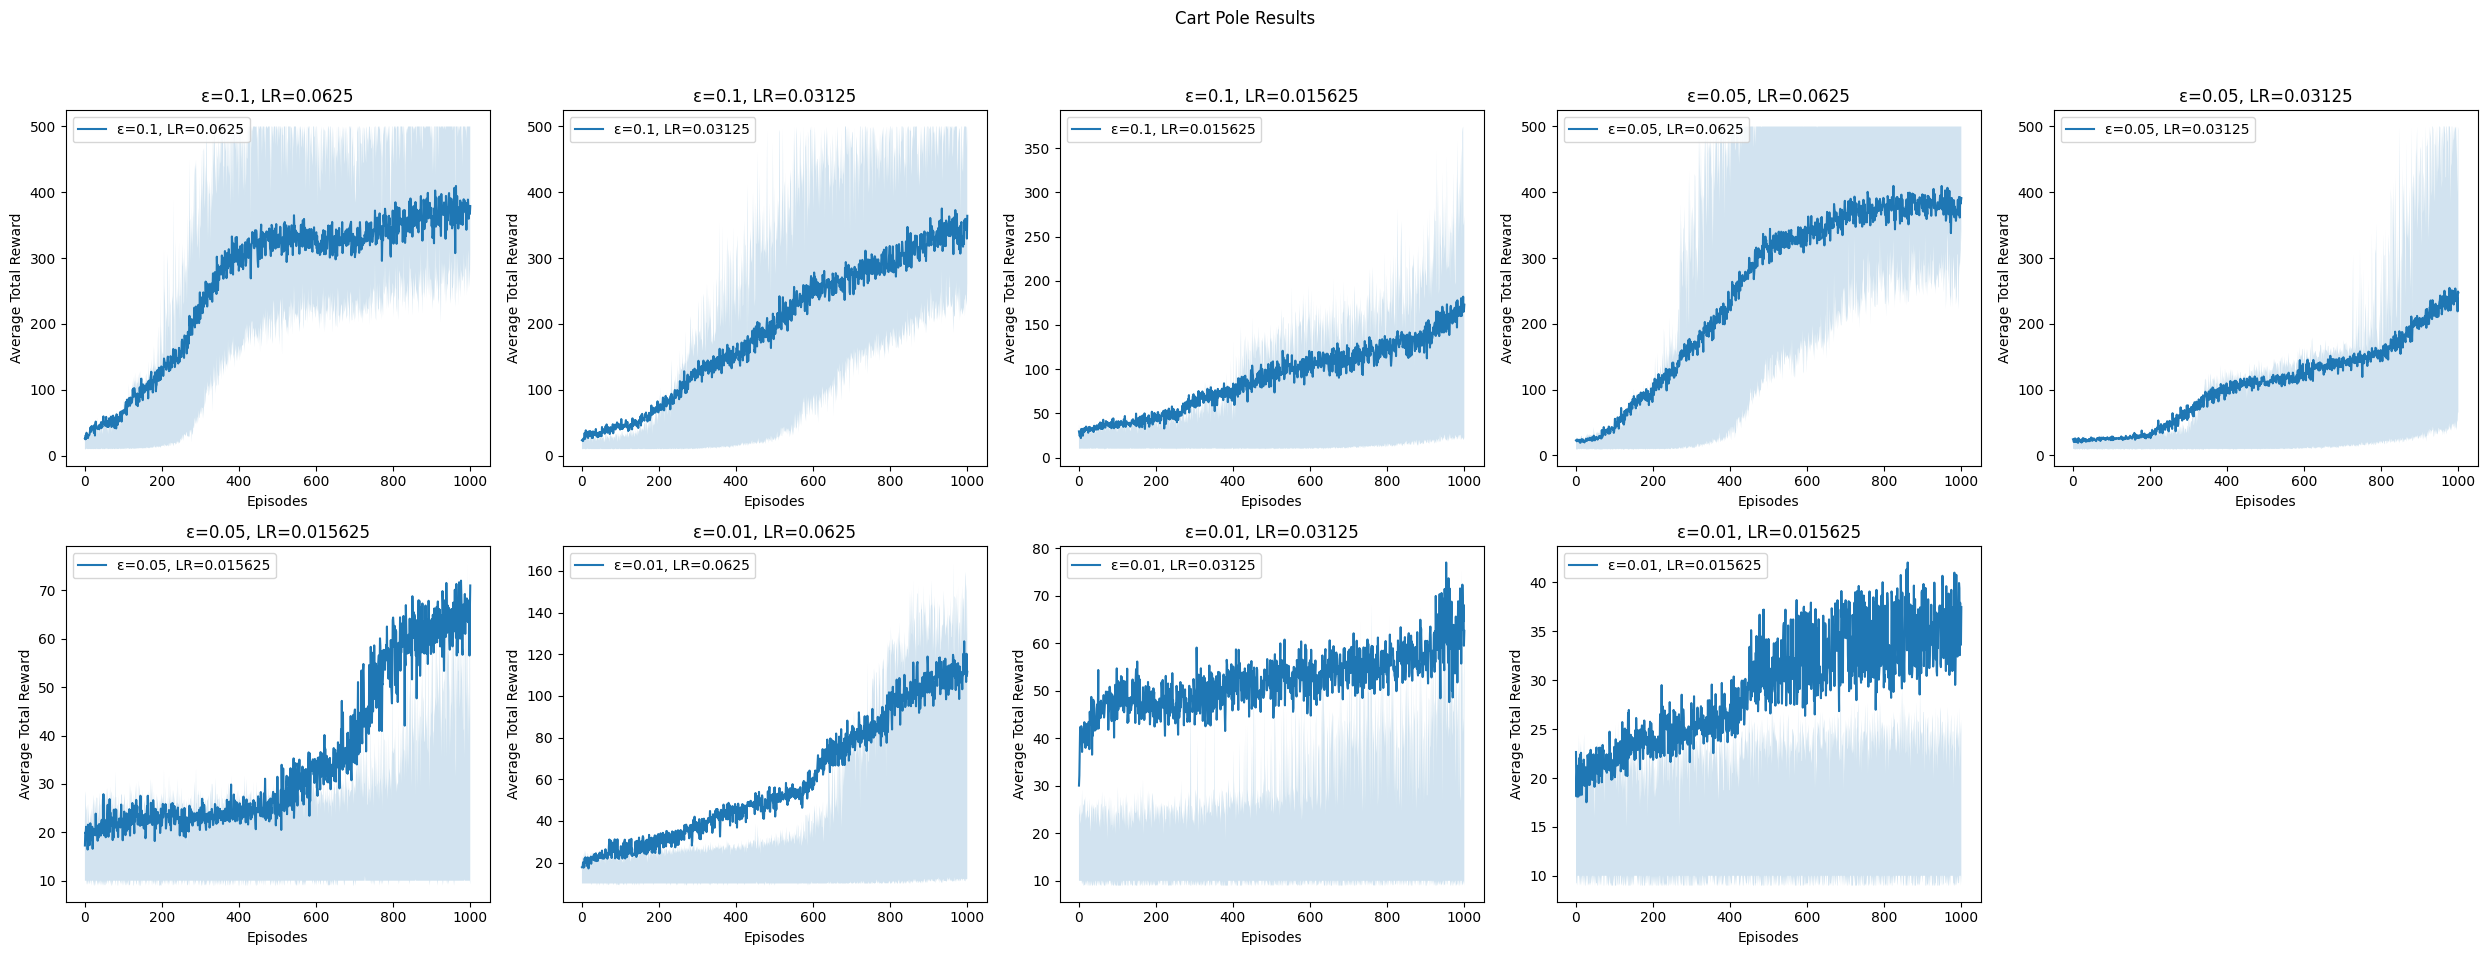

In [ ]:
plot_results(QL_cartPole_experiment_results, 'Cart Pole Results', epsilons, learning_rates, num_episodes)

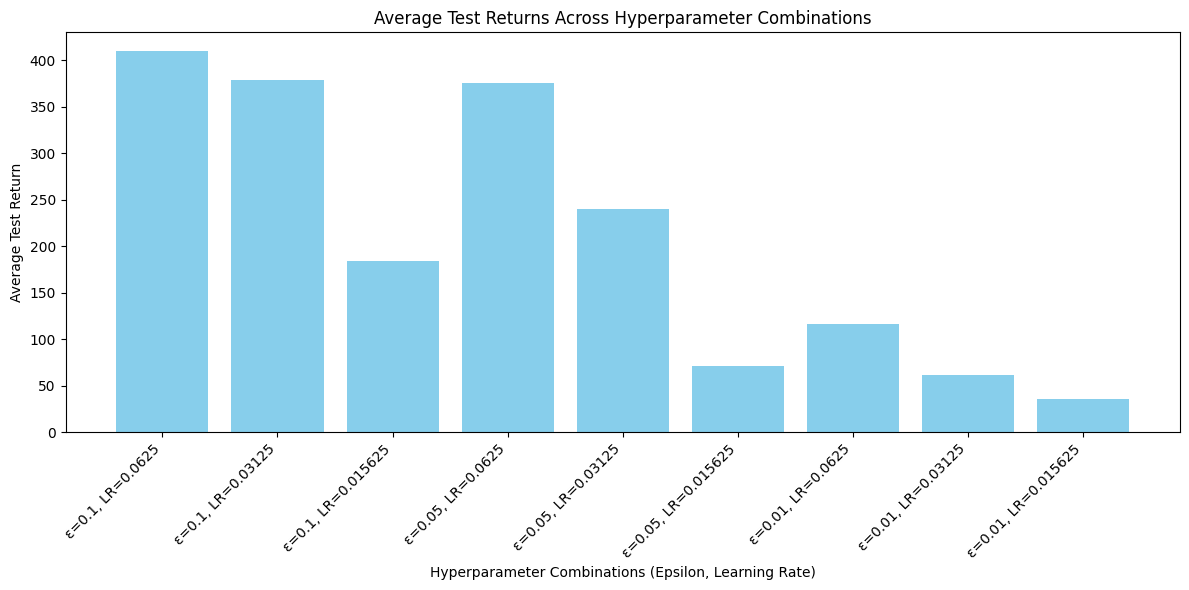

In [ ]:
plot_test_results(QL_cartPole_experiment_test_results, epsilons, learning_rates)

Again, the Q-Learning algorithm learns very well on the cart pole environment as can be shown by the training and test results. However, the results are much more volatile, maybe due to the more random nature of the problem or higher state dimension. On the training side, the interquantile range is wider and even out of the mean across all episodes. Additionally, the learning curves vary a lot with hyperparameter combination. The testing results suggest that more exploration, higher $\epsilon$, leads to better exploitation and thus better average test returns. Moreover, slightly bigger learning rates, 0.025 and 0.0125, lead to better testing reward as well.

#### Expected SARSA

It is worth noting that dividing the learning rates by the number of tilings did not help for Expected Sarsa algorithm in the cart pole environment. Therfore, it was dropped hoping to lead to better results.

In [ ]:
# Experiment parameters
epsilons = [0.1, 0.05, 0.01]  # Exploration rates
num_tilings = 8
learning_rates = np.array([1/4, 1/8, 1/16])  # Step sizes
num_trials = 50
num_episodes = 1000
tile_coder = TileCoder(tiles_per_dim=[8,8,8,8], limits=[[-2.4, 2.4], [-3.4, 3.4], [-.2095,.2095], [-2.2, 2.2]], num_tilings=num_tilings)

ES_cartPole_experiment_results, ES_cartPole_experiment_test_results = run_exp_sarsa_experiment(cart_pole, num_episodes, num_trials, epsilons, learning_rates, tile_coder)

 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 1] Avg Train Reward: 26.33, Avg Test Reward: 75.20
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 2] Avg Train Reward: 27.18, Avg Test Reward: 22.10
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 3] Avg Train Reward: 26.79, Avg Test Reward: 57.50
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 4] Avg Train Reward: 25.70, Avg Test Reward: 19.80
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 5] Avg Train Reward: 26.76, Avg Test Reward: 29.10
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 6] Avg Train Reward: 26.43, Avg Test Reward: 45.90
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 7] Avg Train Reward: 26.51, Avg Test Reward: 16.00
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 8] Avg Train Reward: 27.33, Avg Test Reward: 12.40
 ---- Epsilon: 0.1, Learning Rate: 0.25 ----
[0.1, 0.25, Trial 9] Avg Train Reward: 26.6

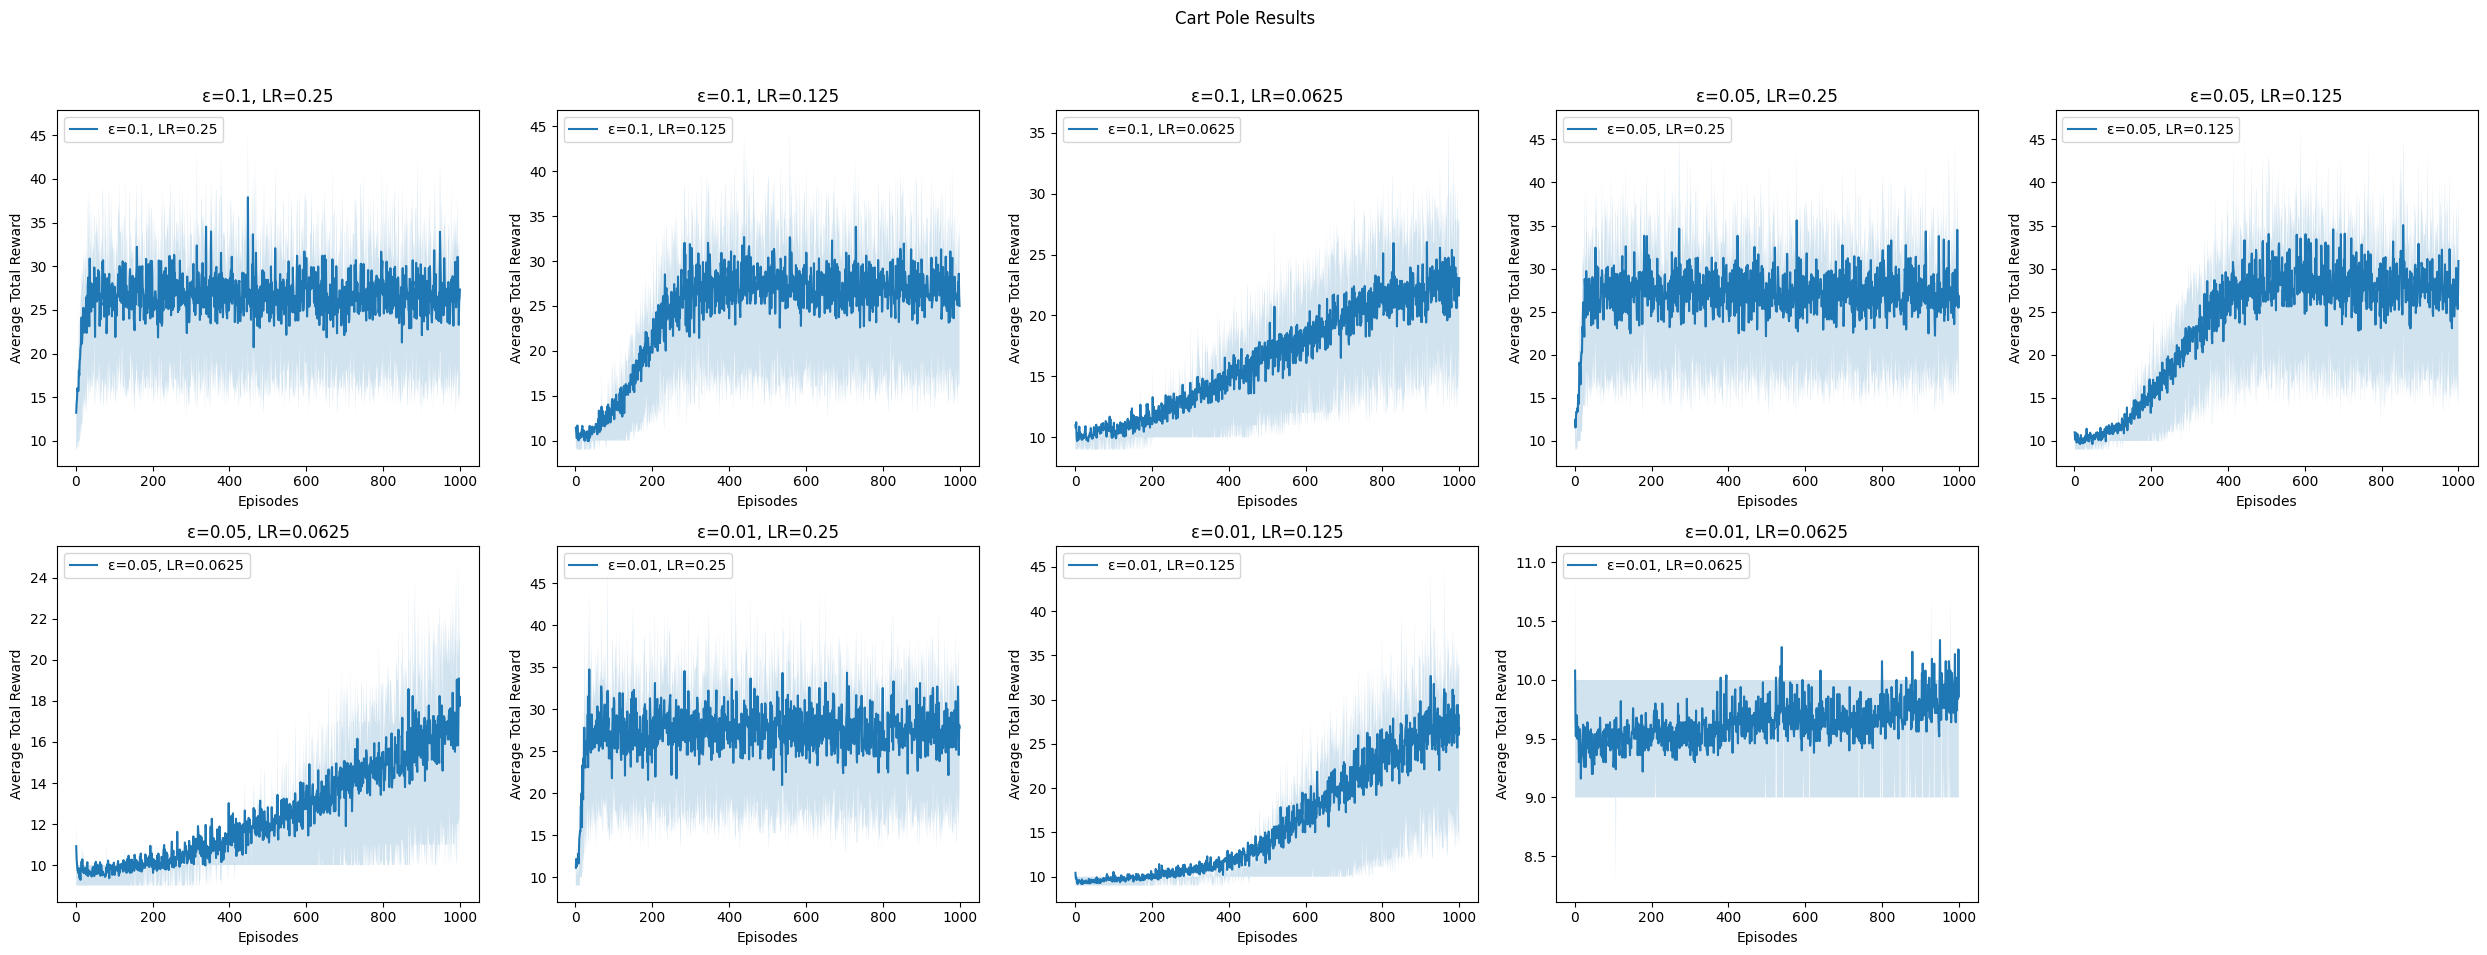

In [ ]:
plot_results(ES_cartPole_experiment_results, 'Cart Pole Results', epsilons, learning_rates, num_episodes)

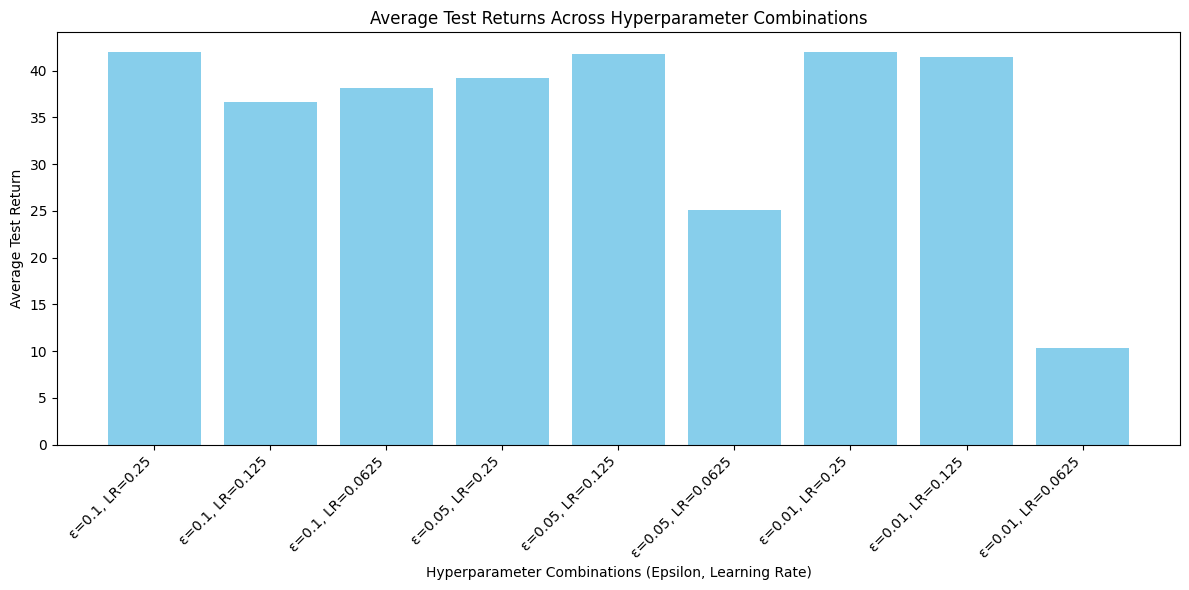

In [ ]:
plot_test_results(ES_cartPole_experiment_test_results, epsilons, learning_rates)

The Expected Sarsa algorithm learns pretty poorly on the cart pole environment, up to 10 times worse than the Q-learning algorithm. For some hyperparameter combination, the algorithm gets stuck in a local optima and stops learning. Similarly to the mountain car environment, training performance is volatile as shown by the wide interquantile ranges. It is worth noting that $\epsilon = 0.01$ and $LR = 0.0625$ does not learn at all. Test results show that bigger learning rates tend to perform a little bit better as mentioned above. Again, the lack of exploration from Expected Sarsa compared to Q-learning could explain why the algorithm does not converge properly. Also, considering the bigger state space of the cart pole environment, this behavior might be more penalized.

# 2: Policy Gradient Theorem

Given the equation of the Policy Gradient Theorem for continuing case from the [textbook](http://incompleteideas.net/book/RLbook2020.pdf}{textbook) p.335
\begin{align*}
    \nabla J(\boldsymbol{\theta}) = \sum_s d^{\pi}(s) \sum_a \nabla \pi(a|s, \boldsymbol{\theta}) q_{\pi}(a|s)
\end{align*}
where $d^{\pi}(s)$ is the steady-state distribution under $\pi$.

For any $z(s, a)$,
\begin{align*}
    & \nabla_z J(\boldsymbol{\theta}) = \frac{\partial J(\boldsymbol{\theta})}{\partial z(s, a)} \\
    &= \sum_s d^{\pi}(s) \sum_{a'} \nabla_z \pi(a'|s, \boldsymbol{\theta}) q_{\pi}(s,a') \\
    &= \sum_s d^{\pi}(s) \sum_{a'} \frac{\partial \pi(a'|s)}{\partial z(s, a)} q_{\pi}(s,a')
\end{align*}

For any $s' \neq s$, $\frac{\partial \pi(a|s')}{\partial z(s, a)} = 0$, therefore
\begin{align*}
    \nabla_z J(\boldsymbol{\theta}) = d^{\pi}(s) \sum_{a'} \frac{\partial \pi(a'|s)}{\partial z(s, a)} q_{\pi}(s,a')
\end{align*}

Since, $\pi$ is a softmax policy, its [derivative](https://www.mldawn.com/the-derivative-of-softmaxz-function-w-r-t-z/) is given by
\begin{align*}
    \frac{\partial \pi(a'|s)}{\partial z(s, a)} =
\begin{cases}
    \pi(a|s) (1-\pi(a|s)) & \text{if $a' = a$} \\
    -\pi(a'|s)\pi(a|s) & \text{if $a' \neq a$} \\
\end{cases}
\end{align*}

Rename $\mathcal{A} = \{a, a', a''\}$, then
\begin{align*}
    \nabla_z J(\boldsymbol{\theta}) &= d^{\pi}(s) \sum_{a'} \frac{\partial \pi(a'|s)}{\partial z(s, a)} q_{\pi}(s,a') \\
    &= d^{\pi}(s)[
        (\frac{\partial \pi(a|s)}{\partial z(s, a)} q_{\pi}(s,a)
        + \frac{\partial \pi(a'|s)}{\partial z(s, a)} q_{\pi}(s,a')
        + \frac{\partial \pi(a''|s)}{\partial z(s, a)} q_{\pi}(s,a''))] \\
    &= d^{\pi}(s)[
        (\pi(a|s) (1-\pi(a|s)) q_{\pi}(s,a))
        + (-\pi(a'|s)\pi(a|s) q_{\pi}(s,a'))
        + (-\pi(a''|s)\pi(a|s) q_{\pi}(s,a''))] \\
    &= d^{\pi}(s) \pi(a|s) [q_{\pi}(s,a) - \pi(a|s)q_{\pi}(s,a) - \pi(a'|s)q_{\pi}(s,a') - \pi(a''|s)q_{\pi}(s,a'')] \\
    &= d^{\pi}(s) \pi(a|s) [q_{\pi}(s,a) - \sum_{a'} \pi(a'|s)q_{\pi}(s,a')] \\
\end{align*}   

By definition, the state-value function is given by $v_{\pi}(s) = \sum_a \pi(a|s)q_{\pi}(s,a)$.
Define $A^{\pi}(s,a) = Q^{\pi}(s, a) - V^{\pi}(s)$, where $Q^{\pi}(s, a) = q_{\pi}(a|s)$ and $V^{\pi}(s) = v_{\pi}(s)$.
Then, the equation becomes
\begin{align*}
    \nabla_z J(\boldsymbol{\theta}) = d^{\pi}(s) \pi(a|s) A^{\pi}(s,a)
\end{align*}

# 3: Policy-based methods with linear function approximation

### Actor Critic

In [ ]:
class Actor_Critic:
    def __init__(self, action_space_size, state_dimension, temperature):
        """
        Implements the Actor-Critic algorithm with linear function approximation for both the actor and critic.
        The actor uses a Boltzmann policy for action selection based on action preferences.

        Parameters:
        - action_space_size (int): Number of possible actions in the action space.
        - state_dimension (int): Dimension of the state vector, based on the tile coding representation.
        - temperature (float): The Temperature hyperparameter.
        """
        # Initialize policy parameters theta with small random values for each action and state dimension.
        self.theta = np.random.uniform(-0.001, 0.001, (action_space_size, state_dimension))
        # Initialize value function parameters with small random values for each state dimension.
        self.V = np.random.uniform(-0.001, 0.001, state_dimension)

        if temperature is None:
            self.is_decreasing_temperature = False
            self.temperature = 1
        else:
            self.is_decreasing_temperature = True
            self.temperature = temperature
    
    def update_temperature(self) -> None:
        if self.is_decreasing_temperature:
            # Decrease the temperature by a small amount
            # Since we have 1000 steps and we fix the minimum temperature to 0.1, we can decrease the temperature by 0.00099 after each episode
            self.temperature = max(0.1, self.temperature - 0.00099)

    def softmax_policy(self, state):
        """
        Computes action probabilities for a given state using softmax function
        on action preferences derived from linear combination of state features.

        Parameters:
        - state (np.array): Encoded state vector for which to compute action probabilities.

        Returns:
        - np.array: probability distribution over actions. SHould be of dimension (action_space_size)
        """
        # Compute action preferences z for all actions given the state vector. z = theta * state_vector
        z = np.dot(self.theta, state) / self.temperature

        # Apply the softmax transformation to obtain a probability distribution over actions.
        exp_z = np.exp((z - np.max(z)))  # Numerical stability: subtract max value in z
        action_probs = exp_z / np.sum(exp_z)

        # Return the action probabilities. Should be of dimension: (action_space_size)
        return action_probs

    def update(self, state, action, reward, next_state, gamma, beta, alpha, done):
        """
        Updates the parameters of the actor and critic using the sampled experience.

        Parameters:
        - state (np.array): current state.
        - action (int): action taken.
        - reward (float): reward received.
        - next_state (np.array): next state after taking action.
        - done (bool): Flag indicating if episode has ended.
        """
        # Estimate the value of the current and next state using the critic's parameters.
        V_s = np.dot(self.V, state)
        V_s_next = 0 if done else np.dot(self.V, next_state)
        
        # Calculate the temporal difference error.
        td_error = reward + gamma * V_s_next - V_s
        
        # Update the critic's value function parameters using the TD error.
        self.V += beta * td_error * state
        
        # Compute the actor's policy gradient.
        action_probs = self.softmax_policy(state)

        grad_log_policy = -state[:, None] * action_probs
        grad_log_policy[:, action] += state

        # Update the actor's policy parameters using the policy gradient scaled by the TD error.
        self.theta += (alpha * td_error * grad_log_policy).T

In [ ]:
def actor_critic(env, actor_critic, tile_coder, episodes, alpha, gamma, beta):
    """
    Implements the one-step Actor-Critic algorithm.

    Parameters:
    - env: environment object.
    - policy (Actor_Critic): Policy approximator.
    - value_function (StateValueFunction): Value function approximator.
    - tile_coder (TileCoder): Tile coder for discretizing the state space.
    - episodes (int): Number of episodes to run the algorithm.
    - learning_rate (float): Learning rate for the policy and value function updates, same for both
    - gamma (float): Discount factor.
    """
    rewards_per_episode = []
    test_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0 # Track the total reward for the episode

        while not done:
            state_vector = tile_coder.get_one_hot_state_vector(state)  # Convert state to feature vector
            action_probs = actor_critic.softmax_policy(state_vector)  # Get action probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs) # Sample action from the action probabilities

            next_state, reward, done, _ = env.step(action)

            next_state_vector = tile_coder.get_one_hot_state_vector(next_state)  # Convert next state

            actor_critic.update(state_vector, action, reward, next_state_vector, gamma, beta, alpha, done)  # Update both actor and critic
            
            state = next_state
            total_reward += reward

        # Append the total reward for the episode to the list.
        rewards_per_episode.append(total_reward)
        actor_critic.update_temperature()

    # Testing phase (greedy policy), for 10 episodes
    for episode in range(10):
        state = env.reset()
        done = False
        total_test_reward = 0

        while not done:
            state_vector = tile_coder.get_one_hot_state_vector(state)
            action_probs = actor_critic.softmax_policy(state_vector) # Predict action probabilities with Boltzmann policy
            action = np.argmax(action_probs) # Greedy action selection

            state, reward, done, _ = env.step(action)
            
            total_test_reward += reward

        test_rewards.append(total_test_reward)

    return rewards_per_episode, test_rewards

### REINFORCE Monte Carlo

In [ ]:
class REINFORCE:
    """
    Implements a linear function approximation for a policy, use Boltzmann policy based on action preferences.

    Parameters:
    - action_space_size (int): Number of possible actions in the action space.
    - state_dimension (int): Dimension of the state vector, based on the tile coding representation.
    - temperature (float): The Temperature hyperparameter.
    """
    def __init__(self, action_space_size, state_dimension, temperature):
        # Initialize policy parameters theta with small random values for each action and state dimension.
        self.theta = np.random.uniform(-0.001, 0.001, (action_space_size, state_dimension))
        if temperature is None:
            self.is_decreasing_temperature = False
            self.temperature = 1
        else:
            self.is_decreasing_temperature = True
            self.temperature = temperature
    
    def update_temperature(self) -> None:
        if self.is_decreasing_temperature:
            # Decrease the temperature by a small amount
            # Since we have 1000 steps and we fix the minimum temperature to 0.1, we can decrease the temperature by 0.00099 after each episode
            self.temperature = max(0.1, self.temperature - 0.00099)

    def softmax_policy(self, state):
        """
        Computes action probabilities for a given state using softmax function
        on action preferences derived from linear combination of state features.

        Parameters:
        - state (np.array): Encoded state vector for which to compute action probabilities.

        Returns:
        - np.array: probability distribution over actions. SHould be of dimension (action_space_size)
        """
        # Compute action preferences z for all actions given the state vector. z = theta * state_vector
        z = np.dot(self.theta, state) / self.temperature

        # Apply the softmax transformation to obtain a probability distribution over actions.
        exp_z = np.exp((z - np.max(z)))  # Numerical stability: subtract max value in z
        action_probs = exp_z / np.sum(exp_z)

        # Return the action probabilities. Should be of dimension: (action_space_size)
        return action_probs

    def update(self, states, actions, rewards, learning_rate, gamma):
        """
        Updates the policy parameters theta using the REINFORCE update rule.

        Parameters:
        - states (np.array): list of the encoded state vector for which the update is computed.
        - actions (int): list of the actions taken.
        - rewards (float): list of reward values.
        - learning_rate (float): Learning rate, determining the step size in the gradient ascent.
        - gamma (float): Gamma parameter.
        """
        # Compute expected return
        G = 0
        for i, state in enumerate(reversed(states)):
          G = rewards[i] + gamma * G
          # Calculate the policy for the given state
          action_probs = self.softmax_policy(state)
          # Calculate the log pi using the provided formula found here:
          # https://ai.stackexchange.com/questions/7147/how-can-we-calculate-the-gradient-of-the-boltzmann-policy-over-reward-function
          grad_log_policy = state - np.sum(action_probs[:, np.newaxis] * state[np.newaxis, :], axis=0)
          # We only apply the gradient update to the taken action
          grad_log_policy *= (actions[i] == np.arange(self.theta.shape[1]))
          self.theta += learning_rate * G * grad_log_policy

In [ ]:
def reinforce(env, policy_approximator, tile_coder, episodes, learning_rate, gamma):
    """
    Implements the REINFORCE algorithm using a linear policy function approximation and Boltzmann (softmax) policy.

    Parameters:
    - env: Environment object.
    - policy_approximator (REINFORCE): Linear policy approximator.
    - tile_coder (TileCoder): Tile coder for discretizing the state space.
    - episodes (int): Number of episodes to run.
    - learning_rate (float): Learning rate value for updates.
    - gamma (float): Discount factor.
    """
    rewards_per_episode = []  # train rewards
    test_rewards = []  # test rewards

    for episode in range(episodes):
        state = env.reset()  # Start a new episode
        done = False
        states = []  # To store state
        actions = [] # To store actions
        rewards = [] # To store rewards

        # Generate an episode following the current policy
        while not done:
            state_vector = tile_coder.get_one_hot_state_vector(state)  # Convert state to feature vector
            action_probs = policy_approximator.softmax_policy(state_vector)  # Get action probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)  # Sample action from the policy distribution

            next_state, reward, done, _ = env.step(action)  # Execute action

            states.append(state_vector)
            actions.append(action)
            rewards.append(reward)

            state = next_state  # Update state

        policy_approximator.update(states, actions, rewards, learning_rate, gamma)
        # Calculate total episode reward and store
        total_reward = sum(rewards)
        rewards_per_episode.append(total_reward)
        policy_approximator.update_temperature()
        
    # Testing phase (greedy policy), for 10 episodes
    for episode in range(10):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_vector = tile_coder.get_one_hot_state_vector(state)  # Convert state to feature vector
            action_probs = policy_approximator.softmax_policy(state_vector)  # Get action probabilities
            action = np.argmax(action_probs)  # Select action with highest probability (greedy)

            next_state, reward, done, _ = env.step(action)  # Execute action

            state = next_state
            total_reward += reward

        test_rewards.append(total_reward)

    return rewards_per_episode, test_rewards

### Mountain Car Experiments

### Helper function to run experiments

In [ ]:
def run_reinforce_experiment(env, episodes, trials, learning_rate, gamma, temperatures, tile_coder, checkpoint_path):
    # Attempt to load existing results to resume
    results, test_results = load_checkpoint(checkpoint_path)
    
    if results is None or test_results is None:  # No checkpoint found, start fresh
        results = np.zeros((len(temperatures), trials, episodes))
        test_results = np.zeros((len(temperatures), trials, 10))
        
        for temp_index, temp in enumerate(temperatures):
            for trial in range(trials):
                # Check if this trial was already completed (results are non-zero)
                if np.any(results[temp_index, trial, :]):
                    continue  # trial already been completed

                # Initialize the Q-approximator with environment-specific dimensions
                policy_approximator = REINFORCE(env.action_space.n, tile_coder.total_tiles, temperature = temp)
                total_rewards, test_rewards = reinforce(env, policy_approximator, tile_coder, episodes, learning_rate, gamma)
                results[temp_index, trial, :] = total_rewards
                test_results[temp_index, trial, :] = test_rewards
                del policy_approximator

                # Print summary for the current trial
                avg_train_reward = np.mean(total_rewards)
                avg_test_reward = np.mean(test_rewards)
                print(f'[Temp {temp}, Trial {trial+1}] Avg Train Reward: {avg_train_reward:.2f}, Avg Test Reward: {avg_test_reward:.2f}')
                # Save checkpoint after each trial
                save_checkpoint(results, test_results, checkpoint_path=checkpoint_path)
    return results, test_results

In [ ]:
def run_actor_critic_experiment(env, episodes, trials, learning_rate, beta, gamma, temperatures, tile_coder, checkpoint_path):
    # Attempt to load existing results to resume
    results, test_results = load_checkpoint(checkpoint_path)
    
    if results is None or test_results is None:  # No checkpoint found, start fresh
        results = np.zeros((len(temperatures), trials, episodes))
        test_results = np.zeros((len(temperatures), trials, 10))
        
        for temp_index, temp in enumerate(temperatures):
            for trial in range(trials):
                # Check if this trial was already completed (results are non-zero)
                if np.any(results[temp_index, trial, :]):
                    continue  # trial already been completed
                
                # Initialize the Q-approximator with environment-specific dimensions
                policy_approximator = Actor_Critic(env.action_space.n, tile_coder.total_tiles, temperature = temp)
                total_rewards, test_rewards = actor_critic(env, policy_approximator, tile_coder, episodes, learning_rate, gamma, beta)
                results[temp_index, trial, :] = total_rewards
                test_results[temp_index, trial, :] = test_rewards
                del policy_approximator

                # Print summary for the current trial
                avg_train_reward = np.mean(total_rewards)
                avg_test_reward = np.mean(test_rewards)
                print(f'[Temp {temp}, Trial {trial+1}] Avg Train Reward: {avg_train_reward:.2f}, Avg Test Reward: {avg_test_reward:.2f}')
                # Save checkpoint after each trial
                save_checkpoint(results, test_results, checkpoint_path=checkpoint_path)
    return results, test_results

In [ ]:
def plot_q3_results(results, title, num_episodes):
    # Adjust for a 2x5 grid. Last subplot in the second row will be unused.
    fig, axs = plt.subplots(2, 1, figsize=(25, 10))  # Adjust figsize as needed
    fig.suptitle(title)

    ax = axs[0]
    data_fixed_temp = results[0, :, :]
    data_decreasing_temp = results[1, :, :]

    means_fixed_temp = np.mean(data_fixed_temp, axis=0)
    lower_bound_fixed_temp = np.quantile(data_fixed_temp, 0.25, axis=0)
    upper_bound_fixed_temp = np.quantile(data_fixed_temp, 0.75, axis=0)

    means_decreasing_temp = np.mean(data_decreasing_temp, axis=0)
    lower_bound_decreasing_temp = np.quantile(data_decreasing_temp, 0.25, axis=0)
    upper_bound_decreasing_temp = np.quantile(data_decreasing_temp, 0.75, axis=0)

    ax.fill_between(np.arange(1, num_episodes + 1), lower_bound_fixed_temp, upper_bound_fixed_temp, alpha=0.2)
    ax.plot(np.arange(1, num_episodes + 1), means_fixed_temp, label=f'REINFORCE Algorithm')
    ax.set_title(f'Fixed Temperature')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Average Total Reward')

    ax = axs[1]
    ax.fill_between(np.arange(1, num_episodes + 1), lower_bound_decreasing_temp, upper_bound_decreasing_temp, alpha=0.2)
    ax.plot(np.arange(1, num_episodes + 1), means_decreasing_temp, label=f'REINFORCE Algorithm')
    ax.set_title(f'Decreasing Temperature')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Average Total Reward')
    
    ax.legend(loc='upper left')

    plt.show()

In [ ]:
def plot_q3_test_results(test_results, labels, title):
    # Average over test episodes for each trial
    avg_over_episodes = np.mean(test_results, axis=2)

    # Average over all trials
    final_avg_test_returns = np.mean(avg_over_episodes, axis=1)

    # Prepare data for plotting
    num_bars = 2
    avg_returns_flat = final_avg_test_returns.flatten()

    # Plotting
    plt.figure(figsize=(3, 6))
    x_positions = np.arange(num_bars)
    plt.bar(x_positions, avg_returns_flat, tick_label=labels, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel('Models')
    plt.ylabel('Average Test Return')
    plt.title(title)
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

#### REINFORCE

In [ ]:
num_episodes = 1000
num_trials = 50
learning_rate = 0.001  # Step size
gamma = 0.99  # Discount factor
temperatures = [0.1, None]  # Temperature for the Boltzmann policy, if None we do decreasing temperature

tile_coder = TileCoder(tiles_per_dim=[8,8], limits=[[-1.2, 0.6], [-0.07, 0.07]], num_tilings=10)

# Assuming tile_coder is defined elsewhere and properly initialized
R_mtn_car_train_rewards, R_mtn_car_test_rewards = run_reinforce_experiment(mtn_car, num_episodes, num_trials, learning_rate, gamma, temperatures, tile_coder, "reinforce_mtn_car_checkpoint.npz")

[Temp 0.1, Trial 1] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 2] Avg Train Reward: -999.79, Avg Test Reward: -1000.00
[Temp 0.1, Trial 3] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 4] Avg Train Reward: -999.83, Avg Test Reward: -1000.00
[Temp 0.1, Trial 5] Avg Train Reward: -1000.00, Avg Test Reward: -898.70
[Temp 0.1, Trial 6] Avg Train Reward: -999.69, Avg Test Reward: -1000.00
[Temp 0.1, Trial 7] Avg Train Reward: -999.95, Avg Test Reward: -1000.00
[Temp 0.1, Trial 8] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 9] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 10] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 11] Avg Train Reward: -999.81, Avg Test Reward: -1000.00
[Temp 0.1, Trial 12] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 13] Avg Train Reward: -999.87, Avg Test Reward: -1000.00
[Temp 0.1, Trial 14] Avg Train Reward: -9

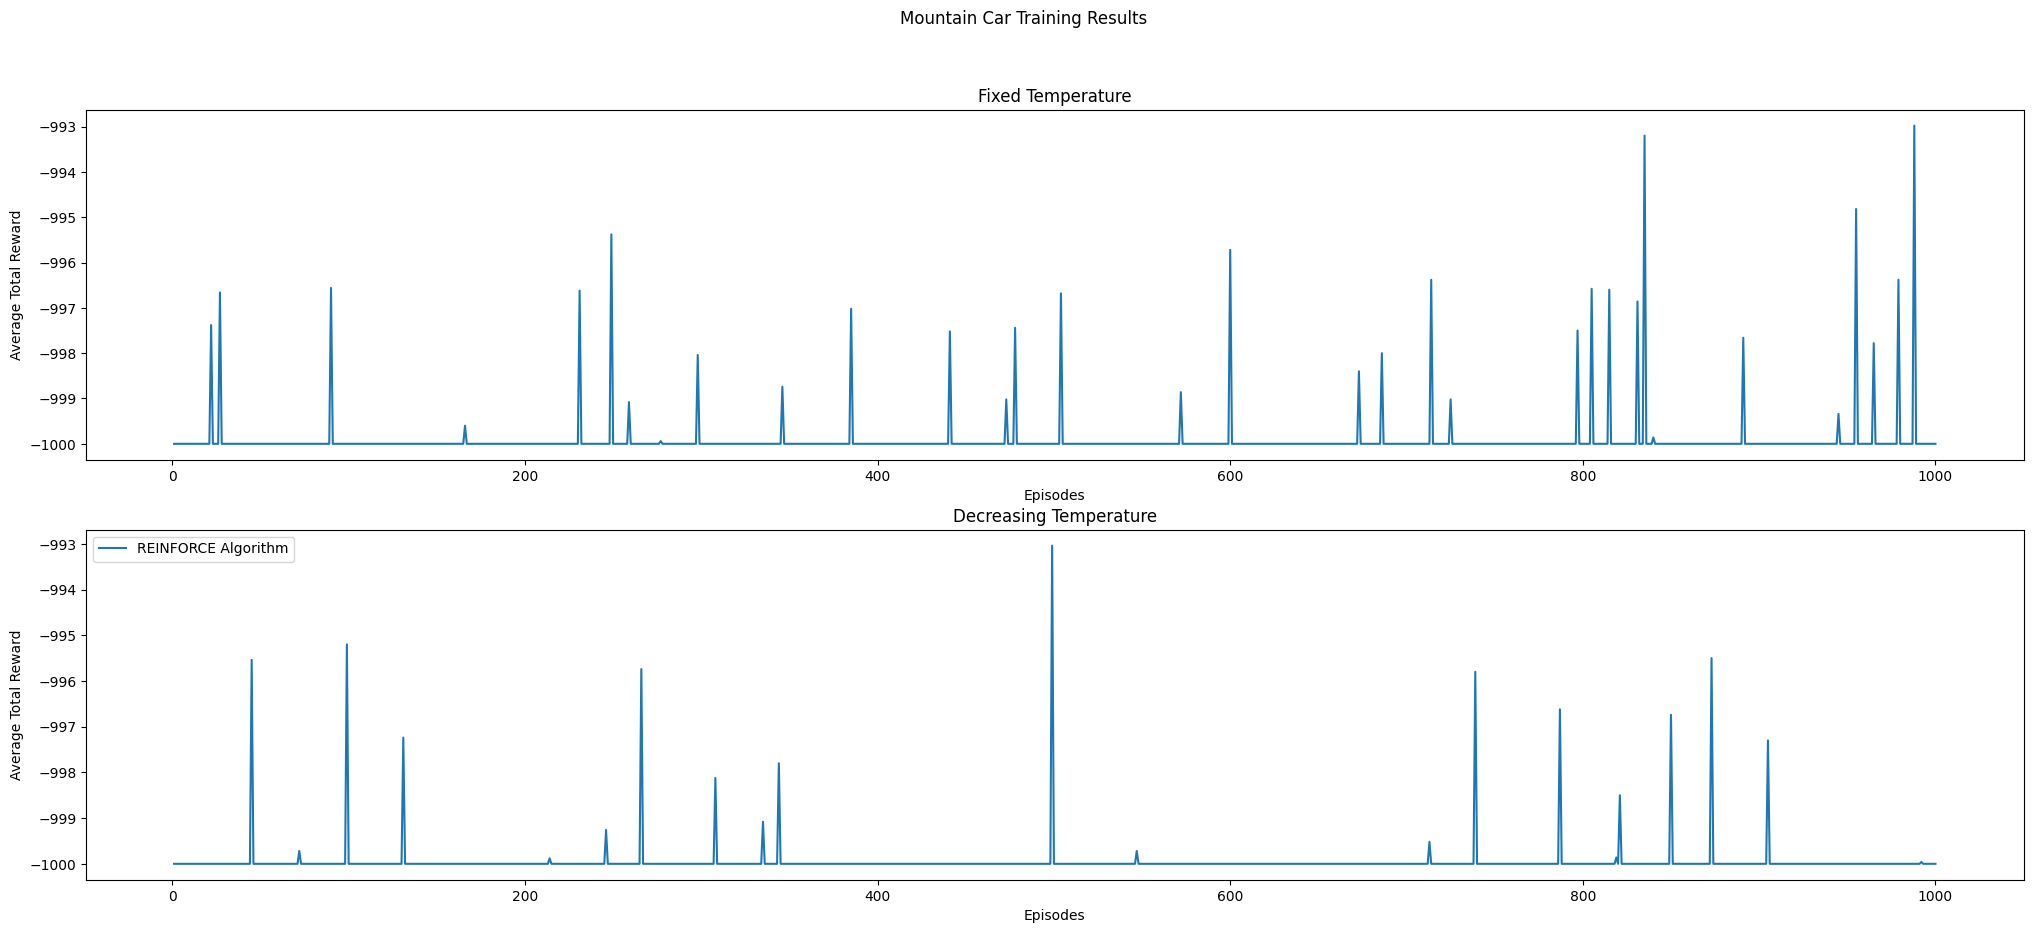

In [ ]:
plot_q3_results(R_mtn_car_train_rewards, 'Mountain Car Training Results', num_episodes)

In the Mountain Car v0 environment, the REINFORCE algorithm's performance was notably poor with both fixed and decreasing temperatures. Despite some occasional spikes in reward, the overall trend was a flat line at the lowest possible average total reward of -1000. This indicates that the agent consistently failed to reach the goal within the allotted 1000 steps, receiving a -1 penalty for each step without success.

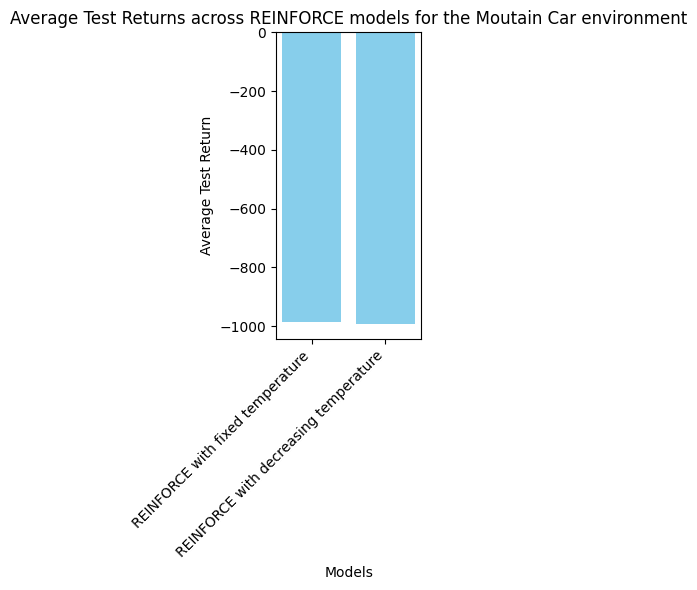

In [ ]:
labels = ["REINFORCE with fixed temperature", "REINFORCE with decreasing temperature"]
title = "Average Test Reward across REINFORCE models for the Moutain Car environment"
plot_q3_test_results(R_mtn_car_test_rewards, labels, title)

#### Actor Critic

In [ ]:
num_episodes = 1000
num_trials = 50
num_tilings = 10
learning_rate = 0.1  # Step size for the actor
beta = 0.1  # Step size for the critic
gamma = 0.99  # Discount factor
temperatures = [0.1, None]  # Temperature for the Boltzmann policy, if None we do decreasing temperature

tile_coder = TileCoder(tiles_per_dim=[8,8], limits=[[-1.2, 0.6], [-0.07, 0.07]], num_tilings=num_tilings)

# Assuming tile_coder is defined elsewhere and properly initialized
AC_mtn_car_train_rewards, AC_mtn_car_test_rewards = run_actor_critic_experiment(mtn_car, num_episodes, num_trials, learning_rate, beta, gamma, temperatures, tile_coder, "ac_mtn_car_checkpoint.npz")

[Temp 0.1, Trial 1] Avg Train Reward: -189.07, Avg Test Reward: -149.10
[Temp 0.1, Trial 2] Avg Train Reward: -126.77, Avg Test Reward: -103.30
[Temp 0.1, Trial 3] Avg Train Reward: -932.21, Avg Test Reward: -1000.00
[Temp 0.1, Trial 4] Avg Train Reward: -139.41, Avg Test Reward: -159.70
[Temp 0.1, Trial 5] Avg Train Reward: -550.33, Avg Test Reward: -111.60
[Temp 0.1, Trial 6] Avg Train Reward: -117.22, Avg Test Reward: -121.30
[Temp 0.1, Trial 7] Avg Train Reward: -114.45, Avg Test Reward: -100.50
[Temp 0.1, Trial 8] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 9] Avg Train Reward: -1000.00, Avg Test Reward: -1000.00
[Temp 0.1, Trial 10] Avg Train Reward: -168.33, Avg Test Reward: -124.90
[Temp 0.1, Trial 11] Avg Train Reward: -123.23, Avg Test Reward: -120.90
[Temp 0.1, Trial 12] Avg Train Reward: -130.70, Avg Test Reward: -143.20
[Temp 0.1, Trial 13] Avg Train Reward: -131.92, Avg Test Reward: -97.00
[Temp 0.1, Trial 14] Avg Train Reward: -365.30, Avg Test

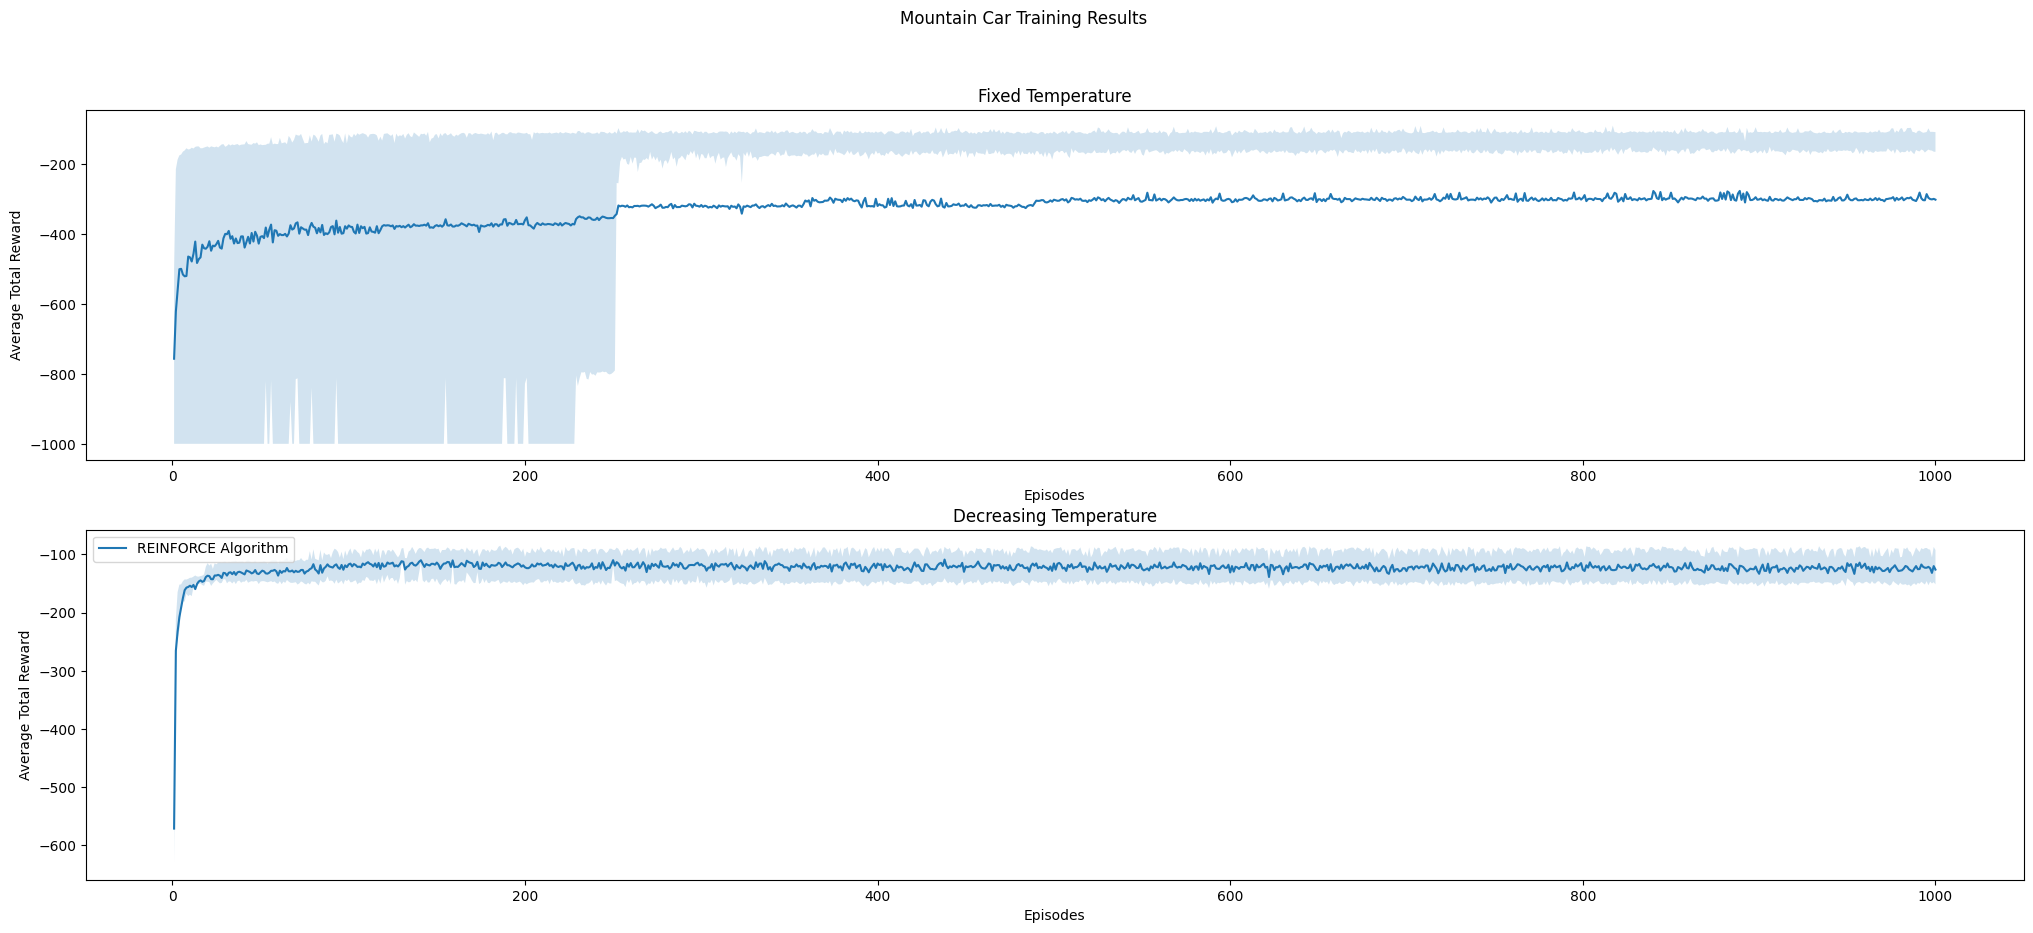

In [ ]:
plot_q3_results(AC_mtn_car_train_rewards, 'Mountain Car Training Results', num_episodes)

Analyzing this resulting graph, the Actor-Critic algorithm's performance in the Mountain Car environment varies with the choice of the temperature parameter. With a fixed temperature of 0.1, the algorithm demonstrates different learning times within the initial 210 episodes over all 50 trials, as indicated by the interquantile ranges which suggest high inconsistencies in the rewards obtained during training at the beginning. In contrast, the approach of decreasing the temperature throughout the episodes, we notice that the algotithm learns in a more stable way across all trials (so the interquantile range is smaller) and the rewards are higher. This suggests that the decreasing temperature approach is more effective as it leads to more consistent and higher rewards.

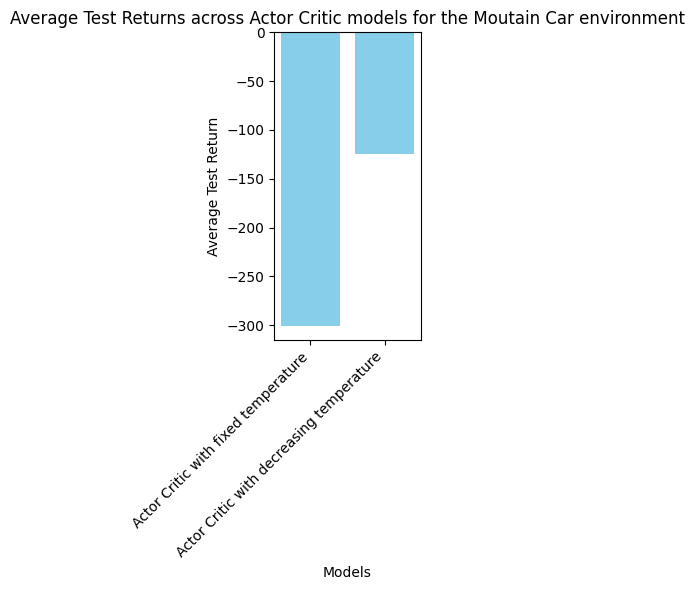

In [ ]:
labels = ["Actor Critic with fixed temperature", "Actor Critic with decreasing temperature"]
title = "Average Test Reward across Actor Critic models for the Moutain Car environment"
plot_q3_test_results(AC_mtn_car_test_rewards, labels, title)

### Result Analysis

First we notice that the REINFORCE algorithm generally performed very poorly on the Mountain Car v0 environment, both when fixing the temperature or decreasing it. Indeed, although we can notice some spikes in the average reward during training, both REINFORCE algorithms always get an average total reward of -1000, which is the worst possible score, as the environment provides a -1 reward for every time step the agent did not reacxh the flag (in this case the maximum number of time steps was set to 1000). Moreover, on testing results both REINFORCE algorithm On the other side, the Actor Critic algorithm performed significantly better than the REINFORCE algorithm, both with fixing the temperature and decreasing it. We note that decreasing the temperature with the number of time steps drastically improved the performance of the algorithm compared to just fixing it. Indeed, with a fixed temperature, the average test return is around -300 while decreasing the temperature increases that average test reward to around -120. 

The Actor-Critic method outperforms REINFORCE in the Mountain Car environment due to its greater sample efficiency. This efficiency stems from the algorithm's ability to update both its policy (the actor) and value function estimates (the critic) incrementally with each step of an episode, leveraging bootstrapped estimates for more frequent and relevant adjustments. On the other hand, REINFORCE updates the policy only at the episode's end, which can hinder learning in environments characterized by longer episodes.

Moreover, REINFORCE relies on the cumulative return for policy updates which can introduce high variance, as the total rewards from an episode can fluctuate greatly—especially in a scenario like Mountain Car, where successfully reaching the flag vastly impacts the return. Actor-Critic, on the other hand, benefits from lower variance in updates. It achieves this by bootstrapping from the critic's value estimates, thus providing a more consistent and reliable signal for learning. This fundamental difference in approach enables Actor-Critic to learn more stable and effective policies faster than REINFORCE.

### Cart Pole Experiments

#### REINFORCE

In [ ]:
num_episodes = 1000
num_trials = 50
num_tilings = 10
learning_rate = 0.01  # Step size
gamma = 0.99  # Discount factor
temperatures = [0.1, None]  # Temperature for the Boltzmann policy, if None we do decreasing temperature

tile_coder = TileCoder(tiles_per_dim=[8,8,8,8], limits=[[-2.4, 2.4], [-3.4, 3.4], [-.2095,.2095], [-2.2, 2.2]], num_tilings=num_tilings)

# Assuming tile_coder is defined elsewhere and properly initialized
R_cart_pole_train_rewards, R_cart_pole_test_rewards = run_reinforce_experiment(cart_pole, num_episodes, num_trials, learning_rate, gamma, temperatures, tile_coder, "reinforce_cart_pole_checkpoint.npz")

[Temp 0.1, Trial 1] Avg Train Reward: 22.75, Avg Test Reward: 29.50
[Temp 0.1, Trial 2] Avg Train Reward: 21.77, Avg Test Reward: 14.80
[Temp 0.1, Trial 3] Avg Train Reward: 21.79, Avg Test Reward: 21.30
[Temp 0.1, Trial 4] Avg Train Reward: 22.34, Avg Test Reward: 20.10
[Temp 0.1, Trial 5] Avg Train Reward: 22.69, Avg Test Reward: 21.20
[Temp 0.1, Trial 6] Avg Train Reward: 21.87, Avg Test Reward: 26.90
[Temp 0.1, Trial 7] Avg Train Reward: 22.73, Avg Test Reward: 20.90
[Temp 0.1, Trial 8] Avg Train Reward: 22.18, Avg Test Reward: 14.30
[Temp 0.1, Trial 9] Avg Train Reward: 22.11, Avg Test Reward: 29.90
[Temp 0.1, Trial 10] Avg Train Reward: 22.32, Avg Test Reward: 20.80
[Temp 0.1, Trial 11] Avg Train Reward: 22.95, Avg Test Reward: 44.90
[Temp 0.1, Trial 12] Avg Train Reward: 22.26, Avg Test Reward: 24.70
[Temp 0.1, Trial 13] Avg Train Reward: 23.23, Avg Test Reward: 53.90
[Temp 0.1, Trial 14] Avg Train Reward: 23.12, Avg Test Reward: 19.80
[Temp 0.1, Trial 15] Avg Train Reward: 22.0

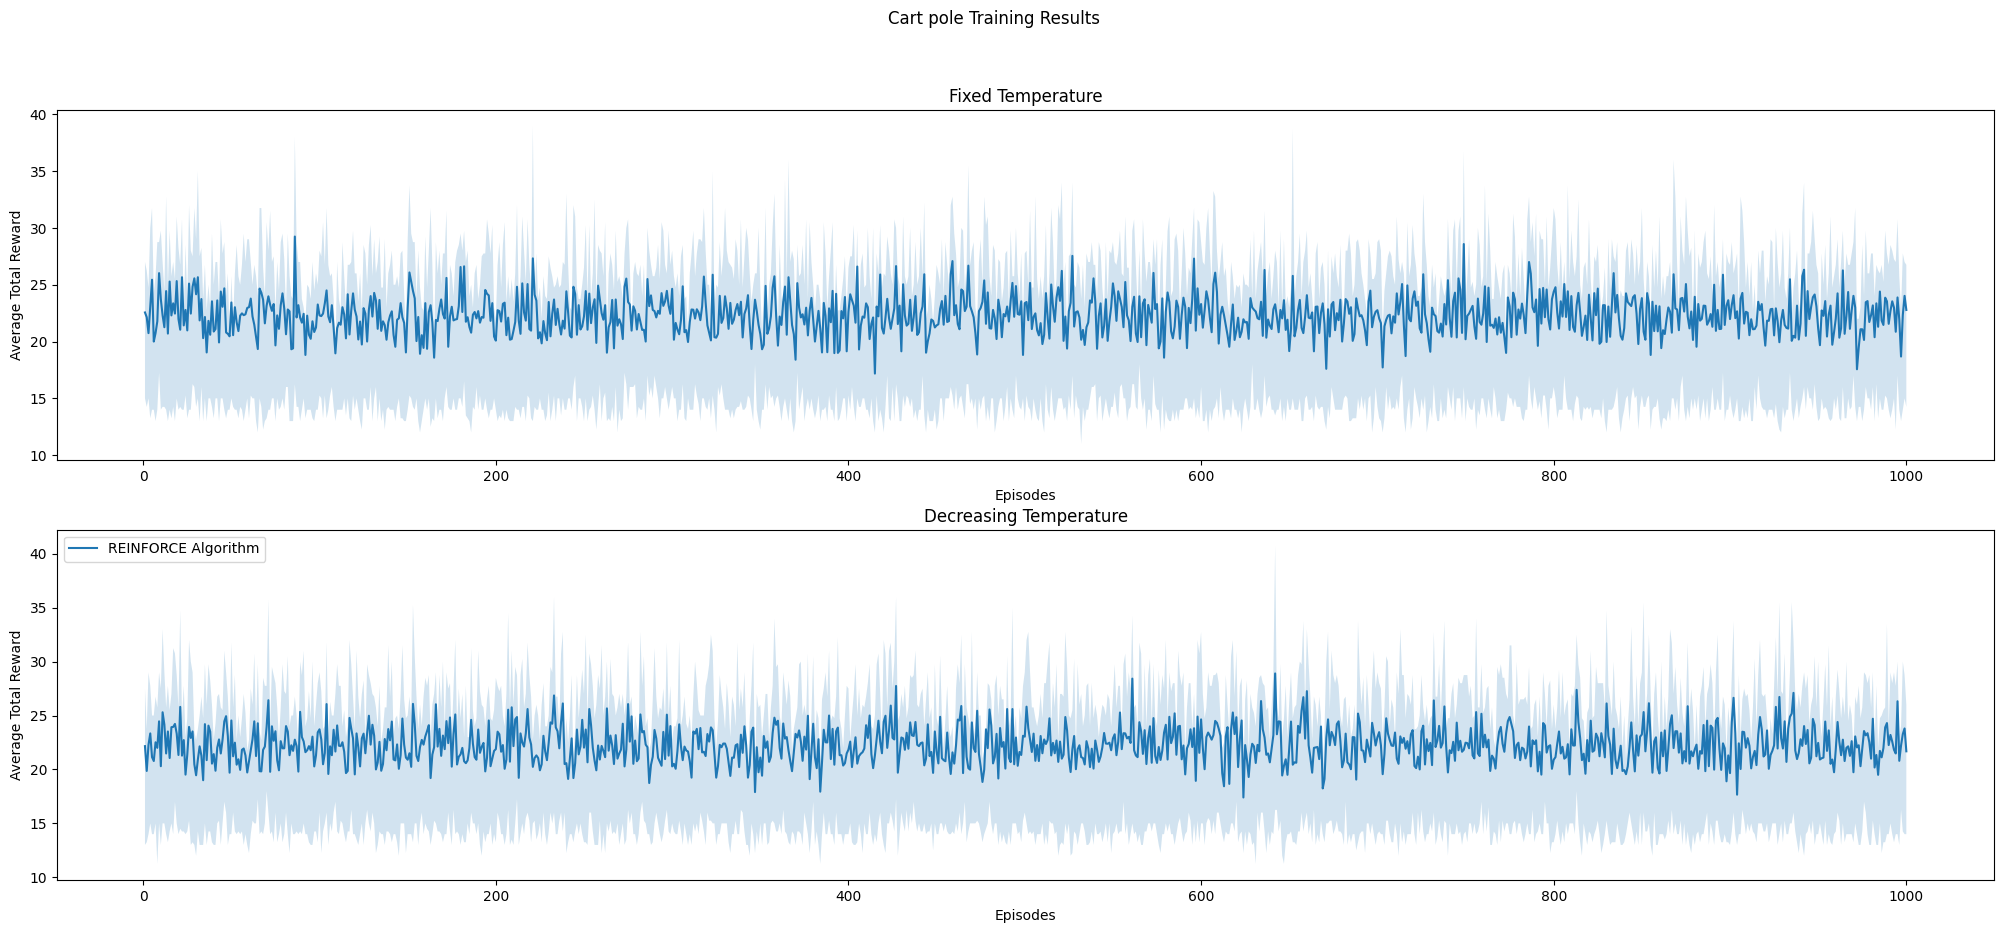

In [ ]:
plot_q3_results(R_cart_pole_train_rewards, 'Cart pole Training Results', num_episodes)

In the CartPole v1 environment, the REINFORCE algorithm seems to exhibit high instability in training rewards, as shown by the variance seen in the above graph. The average reward rarely goes above 35, which implies that the model struggles to learn the task effectively. In the CartPole scenario, the agent receives a reward for each timestep the pole remains upright on the cart. Thus, the total reward corresponds to the number of timesteps before the pole falls. The limited reward ceiling indicates that the algorithm fails to consistently find or maintain a strategy for balancing the pole for an extended period, terminating episodes prematurely when the pole deviates significantly from the vertical.

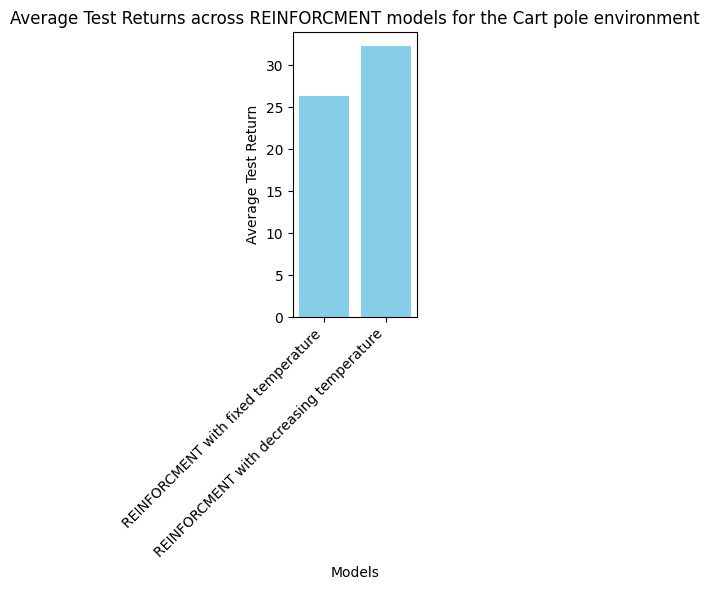

In [ ]:
labels = ["REINFORCMENT with fixed temperature", "REINFORCMENT with decreasing temperature"]
title = "Average Test Rewards across REINFORCMENT models for the Cart pole environment"
plot_q3_test_results(R_cart_pole_test_rewards, labels, title)

#### Actor Critic

In [ ]:
num_episodes = 1000
num_trials = 50
num_tilings = 10
learning_rate = 0.1  # Step size for the actor
beta = 0.1  # Step size for the critic
gamma = 0.99  # Discount factor
temperatures = [0.1, None]  # Temperature for the Boltzmann policy, if None we do decreasing temperature

tile_coder = TileCoder(tiles_per_dim=[8,8,8,8], limits=[[-2.4, 2.4], [-3.4, 3.4], [-.2095,.2095], [-2.2, 2.2]], num_tilings=num_tilings)

# Assuming tile_coder is defined elsewhere and properly initialized
AC_cart_pole_train_rewards, AC_cart_pole_test_rewards = run_actor_critic_experiment(cart_pole, num_episodes, num_trials, learning_rate, beta, gamma, temperatures, tile_coder, "ac_cart_pole_checkpoint.npz")

[Temp 0.1, Trial 1] Avg Train Reward: 118.07, Avg Test Reward: 173.40
[Temp 0.1, Trial 2] Avg Train Reward: 149.52, Avg Test Reward: 172.10
[Temp 0.1, Trial 3] Avg Train Reward: 164.35, Avg Test Reward: 156.10
[Temp 0.1, Trial 4] Avg Train Reward: 221.43, Avg Test Reward: 337.80
[Temp 0.1, Trial 5] Avg Train Reward: 77.93, Avg Test Reward: 97.20
[Temp 0.1, Trial 6] Avg Train Reward: 102.35, Avg Test Reward: 115.60
[Temp 0.1, Trial 7] Avg Train Reward: 42.60, Avg Test Reward: 120.50
[Temp 0.1, Trial 8] Avg Train Reward: 13.61, Avg Test Reward: 21.90
[Temp 0.1, Trial 9] Avg Train Reward: 91.00, Avg Test Reward: 99.70
[Temp 0.1, Trial 10] Avg Train Reward: 122.86, Avg Test Reward: 116.00
[Temp 0.1, Trial 11] Avg Train Reward: 133.39, Avg Test Reward: 129.10
[Temp 0.1, Trial 12] Avg Train Reward: 297.15, Avg Test Reward: 442.70
[Temp 0.1, Trial 13] Avg Train Reward: 102.20, Avg Test Reward: 129.50
[Temp 0.1, Trial 14] Avg Train Reward: 190.98, Avg Test Reward: 325.50
[Temp 0.1, Trial 15] A

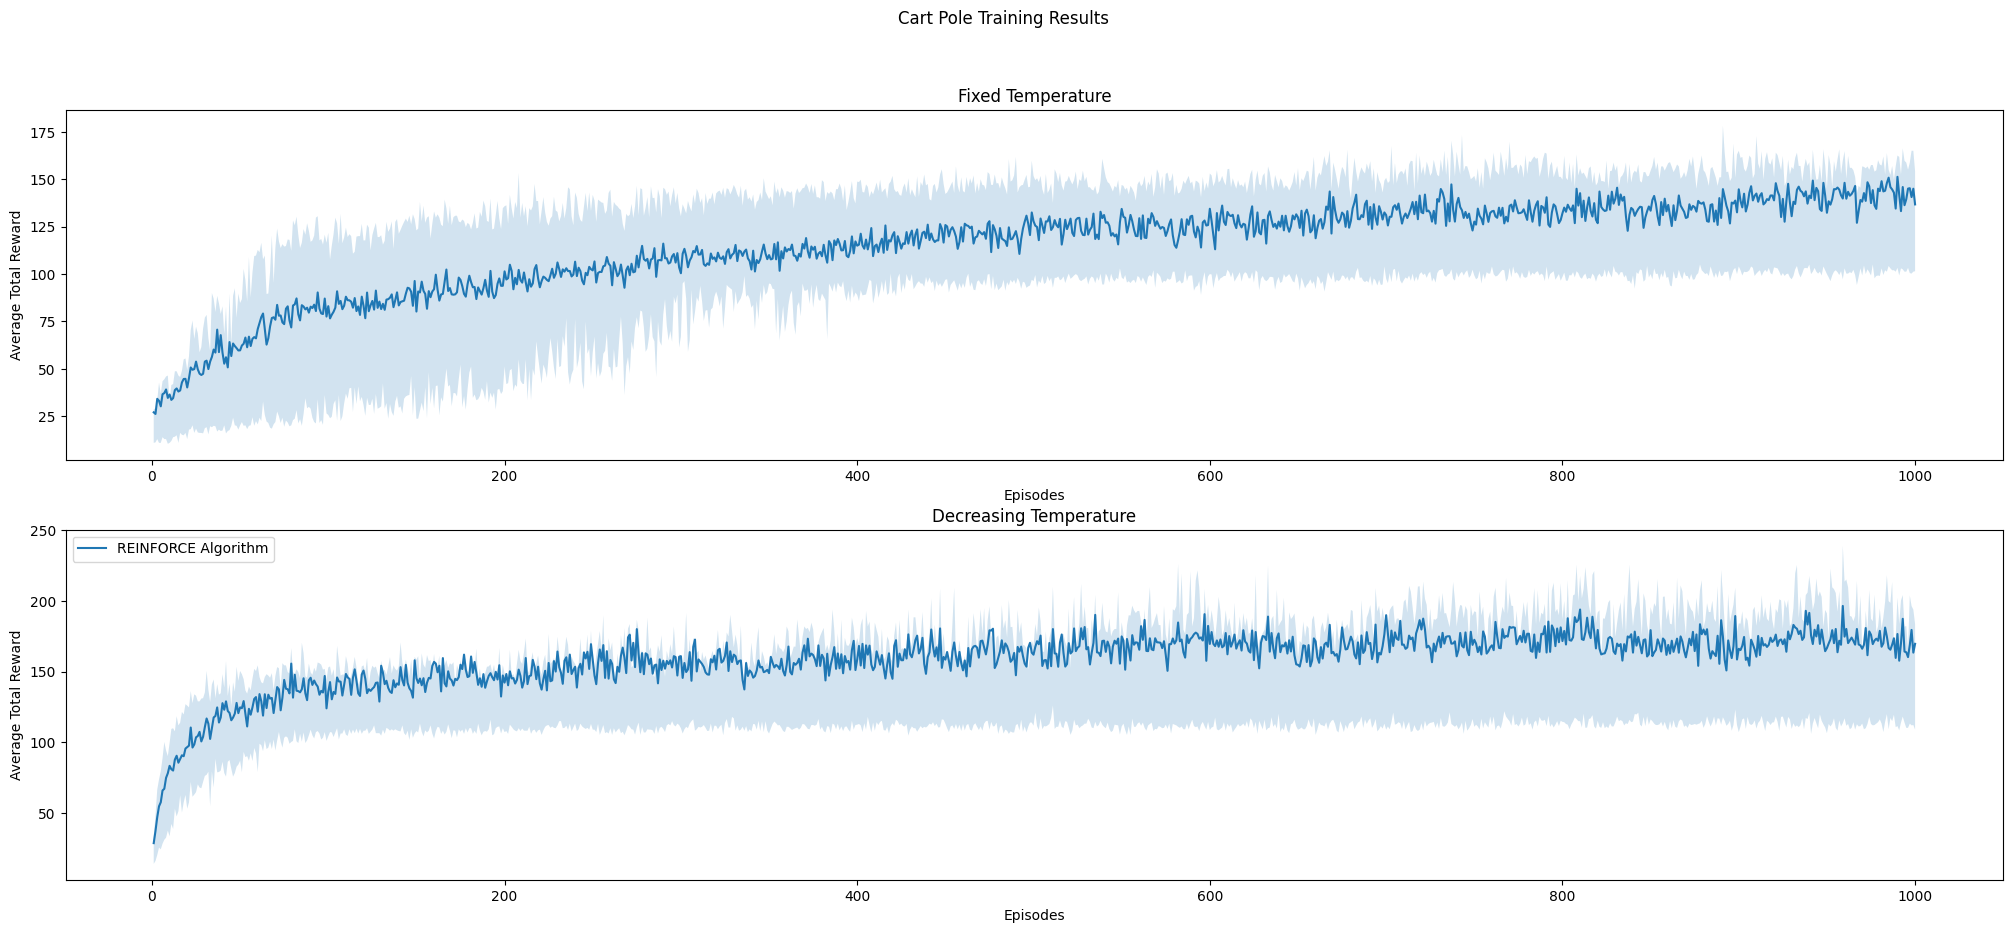

In [ ]:
plot_q3_results(AC_cart_pole_train_rewards, 'Cart Pole Training Results', num_episodes)

From these results, we observe an upward trend in the average training reward over episodes for both fixed and decreasing temperature settings. This gradual increase indicates the algorithm's learning progression with noticeable improvements in balancing the pole on the cart unlike the REINFORCE algorithm.

In the case of a fixed temperature, the average reward displays more volatility, as seen in the broader interquantile range. Conversely, when employing a decreasing temperature, the algorithm exhibits less volatility, indicated by a narrower interquantile range. This reduction in variability suggests a more stable learning process. As the temperature lowers, the policy shifts focus from exploration towards exploitation, consistently refining the strategy to keep the pole balanced.

Comparing the two temperature strategies, the decreasing temperature approach clearly leads to higher rewards. Notably, we can notice that using a fixed temperate shows a constant and slow increase in average total reward where decreasing the temperature shows a more rapid increase in average total reward which then plateaus around the 600th episode. This suggests that the decreasing temperature approach is more effective as it leads to more consistent and higher rewards. This conclusion is smoewhat similar to the MoutainCar environment one.

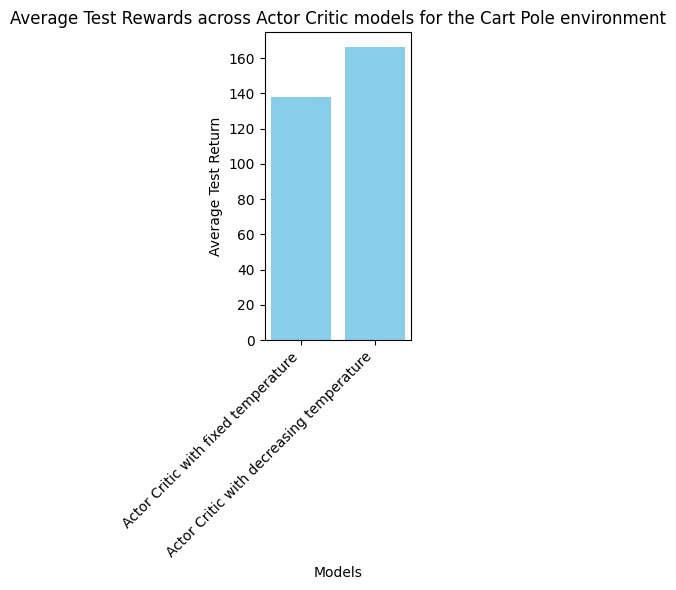

In [ ]:
labels = ["Actor Critic with fixed temperature", "Actor Critic with decreasing temperature"]
title = "Average Test Rewards across Actor Critic models for the Cart Pole environment"
plot_q3_test_results(AC_cart_pole_test_rewards, labels, title)

### Result Analysis

In the CartPole v1 environment, we see a drastic difference in performance between the REINFORCE algorithm and the Actor-Critic method. REINFORCE struggles with unstable training rewards and doesn't manage to push the average training reward much past 35, indicating difficulty in learning to hold the pole on the cart. On the other hand, Actor-Critic shows improvement over time, with both fixed and decreasing temperatures leading to better results. The method is more stable, particularly with a decreasing temperature resulting in higher and more consistent rewards.

In both types of algorithm, we also note that the average testing rewards were always higher when using the decreasing temperature method over the fixed one. Indeed, in the REINFORCEMENT algorithm the test rewards reached 35 using the decreasing temperature method against 26 with a fixed temperature. Actor Critic also performed much better using the decreasing temeprature method yielding an aevrage test return of around 162 against 139 for a fixed temperature.

REINFORCE didn't perform well in the CartPole v1 environment, and its difficulties can be linked to the same issues that impacted its performance in Mountain Car. Each time the pole falls, the episode ends, and REINFORCE is expected to update its policy based on the total cumulative return of the episode. However, this approach introduces a high variance in the policy updates because the rewards can be highly inconsistent from one episode to the next—especially in CartPole, where each episode's length (and thus total reward) varies significantly depending on how long the pole is kept upright. This variance can make it challenging for REINFORCE to learn a stable and effective strategy. The algorithm essentially gets a mixed signal about which actions are truly beneficial for keeping the pole balanced. In contrast, Actor-Critic methods provide more regular and informative updates. They use the critic's value estimates to provide a steadier learning signal—through bootstrapping—and adjust the policy at every step rather than waiting until the end of the episode. This allows for a more nuanced adjustment to the policy, leading to faster and more stable learning.